# Análise do conjunto de dados

Gera gráficos e tabelas com distribuições de dados.

**Entrada:** `dataset.zip`, `datasetpos.zip` e `datasetner.zip`.

- Dentro do arquivo compactado `dataset.zip` está o arquivo `dataset.csv`. Cada linha de `dataset.csv` é formado por `["id","sentencas","documento"]`.
   - `"id"` é o idenficador do documento na base de dados.
  - `"sentencas"` é uma lista com as sentenças do documento. 
  - `"documento"` o documento limpo, mas não segmentado.

- Dentro do arquivo compactado `datasetpos.zip` está o arquivo `datasetpos.csv`. Cada linha do arquivo `datasetpos.csv` é formado por `["id","pos_documento"]`.
  - `"id"` é o idenficador do documento no dataset.
  - `"pos_documento"` é uma lista das sentenças do documento, formado por `"tokens","pos","verbos" e "lemma"`.
    - `"tokens"` é uma lista com os tokens da sentença.
    - `"pos"` é uma lista com as postagging das palavras da sentença.
    - `"verbos"` é uma lista com os verbos da sentença.
    - `"lemma"` é uma lista com os lemmas das palavras da sentença.

- Dentro do arquivo compactado `datasetner.zip` está o arquivo `datasetnes.csv`. Cada linha do arquivo `datasetpos.csv` é formado por `["id","ner_documento"]`.
  - `"id"` é o idenficador do documento no dataset.
  - `"ner_documento"` é uma lista com as entidades reconhecidas do documento, formado por `["indice_sentenca","lista_entidades"]`.
    - `"indice_sentenca"` é o índice da sentença no documento.
    - `"lista_entidades"` é uma lista com as entidades reconhecidas na sentença formado por `["texto entidade"`,`"tipo entidade"`, `"posição inicial"` e `"posição final"]`.    


**Processamento**:
1. Copia e descompacta o arquivo "`dataset.zip`", "`datasetpos.zip`" "`datasetner.zip`" para a máquina local do 
Google Colab.
2. Carrega os arquivos para gerar gráficos e tabelas com distribuições dos dados.

# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório do notebook no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioNotebook():
    """
      Verifica se existe o diretório do notebook no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_NOTEBOOK):  
        # Cria o diretório
        os.makedirs(DIRETORIO_NOTEBOOK)
        logging.info("Diretório do notebook criado: {}".format(DIRETORIO_NOTEBOOK))
    
    return DIRETORIO_NOTEBOOK

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [3]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [4]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModelosParametros:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )    

Biblioteca de limpeza de tela


In [5]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [6]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [7]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [8]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [9]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [10]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [11]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [12]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [13]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do spaCy

https://spacy.io/

Modelos do spaCy para português:
https://spacy.io/models/pt

In [14]:
# Instala dependências do spacy
!pip install -U pip setuptools wheel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
# Instala uma versão específica
!pip install -U spacy==3.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Successfully uninstalled wasabi-1.1.1
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.1
    Uninstalling spacy-3.5.1:
      Successfully uninstalled spacy-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.4.4 which is incompatible.


## 1.8 Instalação do BERT

Instala a interface pytorch para o BERT by Hugging Face. 

https://huggingface.co/docs/transformers/installation



In [16]:
!pip install -U transformers==4.26.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 15.9 MB/s eta 0:00:00


# 2 Parametrização

## Gerais

In [17]:
# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

In [18]:
# Definição dos parâmetros do Modelo.
model_args = ModelosParametros(     
    max_seq_len = 512,
    
    #pretrained_model_name_or_path = "bert-large-cased",
    #pretrained_model_name_or_path = "bert-base-cased"
    #pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    #modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
        
    do_lower_case = False,   # default True  
    output_attentions = False,  # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
)

## Nome do diretório dos arquivos de dados

In [19]:
# Diretório do notebook
DIRETORIO_NOTEBOOK = "SRI"

## Define o caminho para os arquivos de dados

In [20]:
# Diretório local para os arquivos de dados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_NOTEBOOK + "/"

# Diretório no google drive com os arquivos de dados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/" + DIRETORIO_NOTEBOOK + "/data/ChatGPT/"

## Configuração do tamanho da fonte dos gráficos

In [21]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 14
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do documento default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 spaCy

## 3.1 Download arquivo modelo

Uso:
https://spacy.io/usage

Modelos:
https://spacy.io/models

In [22]:
!python -m spacy download $model_args.modelo_spacy

2023-04-14 20:50:50.562637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 1.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


## 3.2 Carrega o modelo

In [23]:
# Import das bibliotecas.
import spacy # Biblioteca do spaCy

nlp = spacy.load(model_args.modelo_spacy)

## 3.3 Funções auxiliares spaCy

### getStopwords

Recupera as stopwords do spaCy

In [24]:
def getStopwords(nlp):
    """
      Recupera as stop words do nlp(Spacy).
    
      Parâmetros:
        `nlp` - Um modelo spaCy carregado.           
    """
    
    spacy_stopwords = nlp.Defaults.stop_words

    return spacy_stopwords 

Lista dos stopwords

In [25]:
print("Quantidade de stopwords: {}.".format(len(getStopwords(nlp))))

print(getStopwords(nlp))

Quantidade de stopwords: 416.
{'um', 'nem', 'sexto', 'quarta', 'vez', 'próxima', 'nove', 'tais', 'mesmo', 'antes', 'dizer', 'estou', 'num', 'foste', 'pelas', 'está', 'estes', 'segundo', 'desse', 'quinta', 'estivestes', 'fez', 'bom', 'meus', 'tem', 'tente', 'lado', 'grupo', 'sua', 'pelos', 'atrás', 'fazem', 'sétima', 'quais', 'seria', 'quero', 'pouca', 'do', 'perto', 'adeus', 'dá', 'pode', 'fui', 'faço', 'vezes', 'primeiro', 'quando', 'geral', 'sob', 'tiveram', 'esta', 'devem', 'vossas', 'oitava', 'tenho', 'mais', 'uns', 'nossos', 'até', 'primeira', 'podia', 'próximo', 'forma', 'quieto', 'seis', 'foi', 'mas', 'nosso', 'todas', 'daquele', 'nos', 'vens', 'pouco', 'corrente', 'parte', 'aquela', 'quem', 'todo', 'tens', 'pela', 'partir', 'esse', 'pontos', 'irá', 'quer', 'vossa', 'zero', 'uma', 'quarto', 'sistema', 'dezanove', 'tuas', 'cima', 'então', 'fora', 'nenhuma', 'somos', 'cinco', 'agora', 'último', 'dezassete', 'ainda', 'nova', 'terceira', 'doze', 'puderam', 'for', 'inicio', 'tentaram

### getSentencaSemStopWord

Retorna uma lista dos tokens sem as stopwords.

In [26]:
def getSentencaSemStopWord(sentenca, stopwords):

  # Lista dos tokens
  lista = []

  # Percorre os tokens da sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é uma stopword
    if token.lower() not in stopwords:
      lista.append(token)

  # Retorna o documento
  return lista

### getDicPOSQtde

Conta as POS Tagging de uma sentença

In [27]:
def getDicPOSQtde(sentenca):

  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades
  novo_dic = dict()
  
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

In [28]:
def getDicTodasPOSQtde(sentenca):

  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades    
  novo_dic = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ":0, "X": 0}
    
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

### getDicTodasPOSQtde

Conta as POS Tagging de uma sentença

In [29]:
def getDicTodasPOSQtde(lista):

  # Dicionário com as tags e quantidades
  conjunto = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ": 0}

  for x in lista:
    valor = conjunto.get(x)
    if valor != None:
      conjunto[x] = valor + 1
    else:
      conjunto[x] = 1

  return conjunto

### getDicTodasNERQtde

Conta as NER de uma sentença

In [30]:
def getDicTodasNERQtde(lista):

  # Dicionário com as classes de entidade e quantidades
  conjunto = {"LOC":0, "MISC":0, "ORG":0, "PER":0}
  
  for x in lista:       
    valor = conjunto.get(x[1])
    if valor != None:
      conjunto[x[1]] = valor + 1
    else:
      conjunto[x[1]] = 1

  return conjunto

### getSomaDicx

Soma os valores de dicionários com as mesmas chaves.

In [31]:
from collections import Counter
from functools import reduce

def atualizaValor(a,b):
    a.update(b)
    return a

def getSomaDic(lista):
    
  # Soma os dicionários da lista
  novo_dic = reduce(atualizaValor, (Counter(dict(x)) for x in lista))
 
  return novo_dic

# 4 BERT

## 4.1 Modelo Pré-treinado BERT

Lista de modelos da comunidade:
* https://huggingface.co/models

Português(https://github.com/neuralmind-ai/portuguese-bert):  
* **"neuralmind/bert-base-portuguese-cased"**
* **"neuralmind/bert-large-portuguese-cased"**

In [32]:
# Import das bibliotecas
from transformers import BertModel

# Carrega o modelo
model = BertModel.from_pretrained(model_args.pretrained_model_name_or_path,
                                  output_attentions=model_args.output_attentions,
                                  output_hidden_states=model_args.output_hidden_states)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 4.2 Tokenizador BERT

O tokenizador utiliza WordPiece, veja em [artigo original](https://arxiv.org/pdf/1609.08144.pdf).

In [33]:
# Import das bibliotecas
from transformers import BertTokenizer

# Carrega o tokenizador
#tokenizer = BertTokenizer.from_pretrained(model_args.pretrained_model_name_or_path)

tokenizer = BertTokenizer.from_pretrained(model_args.pretrained_model_name_or_path, 
                                          do_lower_case=model_args.do_lower_case)

## 4.3 Funções Auxiliares

### getNomeModeloBERT

In [34]:
def getNomeModeloBERT(model_args):
    '''    
    Recupera uma string com uma descrição do modelo BERT para nomes de arquivos e diretórios.
    
    Parâmetros:
    `model_args` - Objeto com os argumentos do modelo.       
    
    Retorno:
    `MODELO_BERT` - Nome do modelo BERT.
    '''

    # Verifica o nome do modelo(default SEM_MODELO_BERT)
    MODELO_BERT = "SEM_MODELO_BERT"
    
    if 'neuralmind' in model_args.pretrained_model_name_or_path:
        MODELO_BERT = "_BERTimbau"
        
    else:
        if 'multilingual' in model_args.pretrained_model_name_or_path:
            MODELO_BERT = "_BERTmultilingual"
            
    return MODELO_BERT

### getTamanhoBERT

In [35]:
def getTamanhoBERT(model_args):
    '''    
    Recupera uma string com o tamanho(dimensão) do modelo BERT para nomes de arquivos e diretórios.
    
    Parâmetros:
    `model_args` - Objeto com os argumentos do modelo.       
    
    Retorno:
    `TAMANHO_BERT` - Nome do tamanho do modelo BERT.
    '''
    
    # Verifica o tamanho do modelo(default large)
    TAMANHO_BERT = "_large"
    
    if 'base' in model_args.pretrained_model_name_or_path:
        TAMANHO_BERT = "_base"
        
    return TAMANHO_BERT  

### Recupera detalhes do BERT

In [36]:
# Verifica o nome do modelo BERT a ser utilizado
MODELO_BERT = getNomeModeloBERT(model_args)

# Verifica o tamanho do modelo(default large)
TAMANHO_BERT = getTamanhoBERT(model_args)

### getPalavrasDesconhecidasBERT

In [37]:
def getPalavrasDesconhecidasBERT(sentenca_token):
  '''    
    Conta o número de palavras desconhecidas na sentença tokenizada pelo BERT.
    
    Parâmetros:
    `sentenca_token` - Lista de tokens da sentença gerado pelo BERT.
    
    Retorno:
    `lista_palavras_desconhecidas` - Lista com as palavras desconhecidas.
  '''
  proximo = False
  achei = False
  token_palavra = ""
  token_bert = []
  lista_palavras_desconhecidas = []      

  for k, token in enumerate(sentenca_token):          
      # Sem ##     
      if "##" not in token:
        token_palavra = token
        token_bert = []
        token_bert.append(token)

      # Verifica se é um token desconhecido
      if "##" in token:       
        achei = True
        # Guarda o token
        token_palavra = token_palavra + token[2:]        
        token_bert.append(token)
        # Se o próximo é continuação do token
        if k+1 < len(sentenca_token):
          if "##" in sentenca_token[k+1]:          
            proximo = True
          else:
            proximo = False
        else:
            proximo = False      

      # Se terminei o token guarda a palavra
      if achei == True and proximo == False:
          achei = False          
          lista_palavras_desconhecidas.append([token_palavra, token_bert])
          token_palavra = ""
          token_bert = []

  return lista_palavras_desconhecidas

# 5 Estatísticas Dataset

## 4.1 Carregamento do Dataset, PoS-Tagging e NER

### 5.1.1 Especifica os nomes dos arquivos de dados



In [38]:
# Nome do arquivo
NOME_ARQUIVO_DATASET = "dataset.csv"
NOME_ARQUIVO_DATASET_COMPACTADO = "dataset.zip"
NOME_ARQUIVO_DATASET_POS = "datasetpos.csv"
NOME_ARQUIVO_DATASET_POS_COMPACTADO = "datasetpos.zip"
NOME_ARQUIVO_DATASET_NER = "datasetner.csv"
NOME_ARQUIVO_DATASET_NER_COMPACTADO = "datasetner.zip"

### 5.1.2 Cria o diretório local para receber os dados

In [39]:
# Importando as bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/SRI


### 5.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [40]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_DATASET_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_DATASET_POS_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_DATASET_NER_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia.")

INFO:root:Terminei a cópia.


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [41]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_DATASET_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_DATASET_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_DATASET_NER_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação.")

INFO:root:Terminei a descompactação.


### 5.1.4 Carregamento das lista com os dados dos arquivos e postagging

#### Carrega o arquivo dos dados e POS

In [42]:
# Import das bibliotecas.
import pandas as pd

# Abre o arquivo e retorna o DataFrame
df_dataset = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_DATASET, sep=";", encoding="UTF-8")
df_dataset_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_DATASET_POS, sep=";", encoding="UTF-8")
df_dataset_ner = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_DATASET_NER, sep=";", encoding="UTF-8")

logging.info("TERMINADO DOCUMENTOS: {}.".format(len(df_dataset)))
logging.info("TERMINADO DOCUMENTOS POS: {}.".format(len(df_dataset_pos)))
logging.info("TERMINADO DOCUMENTOS NER: {}.".format(len(df_dataset_ner)))

INFO:root:TERMINADO DOCUMENTOS: 10.
INFO:root:TERMINADO DOCUMENTOS POS: 10.
INFO:root:TERMINADO DOCUMENTOS NER: 10.


In [43]:
df_dataset.sample(5)

,id,sentencas,documento
1,2,['A inteligência artificial é uma disciplina q...,A inteligência artificial é uma disciplina que...
8,9,['A inteligência artificial é uma tecnologia q...,A inteligência artificial é uma tecnologia que...
5,6,['A inteligência artificial é um campo interdi...,A inteligência artificial é um campo interdisc...
7,8,['A inteligência artificial é uma área da ciên...,A inteligência artificial é uma área da ciênci...
3,4,['A inteligência artificial é um conjunto de t...,A inteligência artificial é um conjunto de téc...


In [44]:
df_dataset_pos.sample(5)

,id,pos_documento
1,2,"[[['A', 'inteligência', 'artificial', 'é', 'um..."
5,6,"[[['A', 'inteligência', 'artificial', 'é', 'um..."
2,3,"[[['A', 'inteligência', 'artificial', 'é', 'um..."
3,4,"[[['A', 'inteligência', 'artificial', 'é', 'um..."
8,9,"[[['A', 'inteligência', 'artificial', 'é', 'um..."


In [45]:
df_dataset_ner.sample(5)

,id,ner_documento
7,8,"[[0, []]]"
0,1,"[[0, []]]"
1,2,"[[0, []]]"
4,5,"[[0, []]]"
5,6,"[[0, []]]"


#### Corrigir os tipos de colunas dos dados, POS e NER

Em lista documento:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em lista pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

Em lista ner:
- coluna 1 - `ner_documento` carregadas do arquivo vem como string e não como lista.

In [46]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
df_dataset["sentencas"] = df_dataset["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
df_dataset_pos["pos_documento"] = df_dataset_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
df_dataset_ner["ner_documento"] = df_dataset_ner["ner_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO DOCUMENTOS: {}.".format(len(df_dataset)))
logging.info("TERMINADO CORREÇÃO DOCUMENTOS POS: {}.".format(len(df_dataset_pos)))
logging.info("TERMINADO CORREÇÃO DOCUMENTOS NER: {}.".format(len(df_dataset_ner)))

INFO:root:TERMINADO CORREÇÃO DOCUMENTOS: 10.
INFO:root:TERMINADO CORREÇÃO DOCUMENTOS POS: 10.
INFO:root:TERMINADO CORREÇÃO DOCUMENTOS NER: 10.


#### Criando dados indexados 

In [47]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
df_dataset_indexado = df_dataset.set_index(["id"])
df_dataset_indexado.head()

,sentencas,documento
id,,
1,[A inteligência artificial é uma área da ciênc...,A inteligência artificial é uma área da ciênci...
2,[A inteligência artificial é uma disciplina qu...,A inteligência artificial é uma disciplina que...
3,[A inteligência artificial é um campo da tecno...,A inteligência artificial é um campo da tecnol...
4,[A inteligência artificial é um conjunto de té...,A inteligência artificial é um conjunto de téc...
5,[A inteligência artificial é um ramo da ciênci...,A inteligência artificial é um ramo da ciência...


In [48]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
df_dataset_pos_indexado = df_dataset_pos.set_index(["id"])
df_dataset_pos_indexado.head()

,pos_documento
id,
1,"[[[A, inteligência, artificial, é, uma, área, ..."
2,"[[[A, inteligência, artificial, é, uma, discip..."
3,"[[[A, inteligência, artificial, é, um, campo, ..."
4,"[[[A, inteligência, artificial, é, um, conjunt..."
5,"[[[A, inteligência, artificial, é, um, ramo, d..."


In [49]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
df_dataset_ner_indexado = df_dataset_ner.set_index(["id"])
df_dataset_ner_indexado.head()

,ner_documento
id,
1,"[[0, []]]"
2,"[[0, []]]"
3,"[[0, []]]"
4,"[[0, []]]"
5,"[[0, []]]"


## 5.2 Estatísticas

### 5.2.1 Processamento estatísticas



In [50]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Lista das estatísticas
stats_documentos = []
stats_documentos_pos = []
stats_documentos_ner = []
stats_documentos_dic_pos = []
stats_documentos_dic_ner =[]
stats_sentencas = []
stats_sentencas_dic_pos = []
stats_sentencas_dic_ner = []

# Dicionário de ocorrência de palavras
dicionario_palavras = {}
# Lista de palavras desconhecidas
lista_palavras_desconhecidas_geral = []
# Lista do documento tokenizado
documento_tokenizado = []

# Declaração e inicialização de contadores do conjunto de dados
total_sentencas_geral = 0
total_palavras_geral = 0
total_palavras_sem_stopwords_geral = 0
total_tokens_geral = 0
total_entidades_geral = 0
total_abaixo_512_geral = 0
total_2_ou_mais_locucoes_verbais = 0
total_sentencas_com_uma_palavra_geral = 0
total_verbos_documento_geral = 0
total_verbos_aux_documento_geral = 0
total_substantivo_documento_geral = 0
total_verbos_aux_substantivo_documento_geral = 0

print("Processando",len(df_dataset),"documentos")

# Barra de progresso dos documentos
df_dataset_bar = tqdm_notebook(df_dataset.iterrows(), desc=f"Documentos", unit=f" documento", total=len(df_dataset))

# Percorre os documentos do conjunto de dados
for i, linha_documento in df_dataset_bar:  
    # Recupera o id do documento
    id_documento = linha_documento["id"]
    #print("id_documento:",id_documento)
 
    # Carrega a lista das sentenças do documento de acordo com o tipo armazenado
    lista_sentenca_documento = linha_documento["sentencas"]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Localiza e carrega a lista das POSTagging das sentenças do documento de acordo com o tipo armazenado
    # Considera somente a posição 1 com as sentenças
    lista_pos_documento = df_dataset_pos.iloc[i][1]    
    #print("lista_pos_documento:",lista_pos_documento)
    #print("len(lista_pos_documento):",len(lista_pos_documento))  

    # Localiza e carrega a lista das NER das sentenças do documento de acordo com o tipo armazenado
    # Descarta a posição 0 com o id do documento e considera somente a posição 1 com as entidades
    lista_ner_documento = df_dataset_ner.iloc[i][1]    
    # print("lista_ner_documento:",lista_ner_documento)
    # print("len(lista_ner_documento):",len(lista_ner_documento))  
    
    # Calcula o total de sentenças do documento
    total_sentencas_geral = total_sentencas_geral + len(lista_sentenca_documento)

    # Inicialização contadores de documento
    total_palavras_documento = 0    
    total_palavras_sem_stopword_documento = 0
    total_tokens_BERT_documento = 0
    total_locucoes_verbais_documento = 0
    total_entidades_documento = 0    
    total_verbos_documento = 0
    total_verbos_aux_documento = 0
    total_substantivo_documento = 0
    total_verbos_aux_substantivo_documento = 0

    lista_palavras_desconhecidas_documento = []
    
    # Acumula os dicionários de POS das sentenças
    lista_dic_pos_doc  = []

    # Acumula os dicionários de NER das sentenças
    lista_dic_ner_doc  = []

    # Acumula a lista de NER das sentenças
    stats_sentencas_ner =[]

    # Acumula a lista de  POS das sentenças
    stats_sentencas_pos = []

    # Guarda as sentenças tokenizadas pelo BERT do documento
    documento_tokenizado_sentenca = []
  
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      #print("sentenca:",sentenca)

      # Recupera a lista dos tokens, PoS-Tagging, Verbos e entidades da sentença
      sentenca_token = lista_pos_documento[j][0]
      #print("sentenca_token:",sentenca_token)
      #print("len(sentenca_token):",len(sentenca_token))
      sentenca_pos = lista_pos_documento[j][1]
      #print("sentenca_pos:",sentenca_pos)
      sentenca_verbos = lista_pos_documento[j][2]
      #print("sentenca_verbos:",sentenca_verbos)
      # Recupera a lista das NER da sentença
      sentenca_ner = lista_ner_documento[j][1]
      # print("sentenca_ner:",sentenca_ner)
      
      ######### Estatístidas das Entidades Nomeadas  
      # Guarda as entidades da sentença
      entidade_sentenca_ner = []

      qtde_ner_sentenca = 0

      # Percorre as entidades da sentença
      for k, entidade in enumerate(sentenca_ner):
        #print(entidade[0], entidade[1])
        # Gera lista das NER da sentença
        entidade_sentenca_ner.append([linha_documento[0], j, entidade[0], entidade[1]])      
        # Conta o total de entidades do documento
        qtde_ner_sentenca = qtde_ner_sentenca + 1

      # Guarda as entidades da sentença 
      stats_sentencas_ner = stats_sentencas_ner + entidade_sentenca_ner

      # Gera as estatísticas de NER da sentença
      contaNERSentenca = getDicTodasNERQtde(sentenca_ner)
      
      # Registra as estatísticas de entidades da sentença
      stats_sentencas_dic_ner.append([linha_documento[0], j, contaNERSentenca])

      # Acumula o dicionário de ner da sentença ao documento
      lista_dic_ner_doc .append(contaNERSentenca)

      ######### Estatísticas das palavras e PoS      
      # Quantidade de palavras por Sentença
      qtdePalavra = len(sentenca_token)

      # Conta sentenças com uma palavra
      if qtdePalavra == 1:
        total_sentencas_com_uma_palavra_geral = total_sentencas_com_uma_palavra_geral + 1
        print("sentenca_token:",sentenca_token)
        print(linha_documento)

      # Retorna uma lista com os verbos da sentença      
      qtde_locucoes_verbais_sentenca = len(sentenca_verbos)
      total_locucoes_verbais_documento = total_locucoes_verbais_documento + qtde_locucoes_verbais_sentenca

      if qtde_locucoes_verbais_sentenca >= 2:
          total_2_ou_mais_locucoes_verbais = total_2_ou_mais_locucoes_verbais + 1
      
      # Retorna os tokens da sentença sem as stopwords
      sentencaSemStopWords = getSentencaSemStopWord(sentenca_token, getStopwords(nlp))
      
      # Quantidade de tokens por Sentença sem as stopwords
      qtde_palavra_sem_stopword = len(sentencaSemStopWords)
            
      # Acumula a quantidade de palavras da Sentença
      total_palavras_documento = total_palavras_documento + qtdePalavra

      # Acumula a quantidade de palavras da Sentença sem stopwords
      total_palavras_sem_stopword_documento = total_palavras_sem_stopword_documento + qtde_palavra_sem_stopword

      # Divide a Sentença em tokens do BERT
      sentenca_tokenizada = tokenizer.tokenize(sentenca)

      # Guarda a sentença tokenizada do documento
      documento_tokenizado_sentenca = documento_tokenizado_sentenca + sentenca_tokenizada

      # Quantidade de tokens por Sentença
      qtde_token_BERT = len(sentenca_tokenizada)     
      
      # Recupera as palavras desconhecidas pelo BERT (com ##)
      lista_palavras_desconhecidas_sentenca = getPalavrasDesconhecidasBERT(sentenca_tokenizada)
      
      # Acumula a quantidade de tokens da Sentença
      total_tokens_BERT_documento = total_tokens_BERT_documento + qtde_token_BERT

      # Guarda as postagging das palavras da sentença
      palavra_sentenca_pos = []
 
      qtde_verbo_sentenca = 0
      qtde_verbo_aux_sentenca = 0
      qtde_substantivo_sentenca = 0
      qtde_verbo_aux_substantivo_sentenca = 0

      # Percorre as palavras da sentença
      for k, palavra in enumerate(sentenca_token):
        # Gera lista das POS Tagging  das palavras da sentença 
        palavra_sentenca_pos.append([linha_documento[0], j, palavra, sentenca_pos[k]])
        
        # Atualiza o dicionário das palavras da sentença
        valor = dicionario_palavras.get(palavra)
        if valor != None:
            dicionario_palavras[palavra] = valor + 1
        else:
            dicionario_palavras[palavra] = 1
        
        # Avalia o tipo PoS das palavras da sentença
        if sentenca_pos[k] in ["VERB"]:
            qtde_verbo_sentenca = qtde_verbo_sentenca  + 1
        if sentenca_pos[k] in ["VERB","AUX"]:
            qtde_verbo_aux_sentenca = qtde_verbo_aux_sentenca  + 1
        if sentenca_pos[k] in ["NOUN"]:
            qtde_substantivo_sentenca = qtde_substantivo_sentenca + 1
        if sentenca_pos[k] in ["VERB","NOUN","AUX"]:                    
            qtde_verbo_aux_substantivo_sentenca = qtde_verbo_aux_substantivo_sentenca  + 1

      # Registra as estatística da Sentença
      stats_sentencas.append(
         {  
            "id": id_documento,  
            "sentenca": j,  
            "qtdepalavras" : qtdePalavra,                        
            "qtdetokensbert" : qtde_token_BERT,
            "qtdepalavrassemstopword" : qtde_palavra_sem_stopword,
            "qtdelocverbo" : qtde_locucoes_verbais_sentenca ,
            "qtdeverbo" : qtde_verbo_sentenca ,
            "qtdeverboaux" : qtde_verbo_aux_sentenca,
            "qtdesubstantivo" : qtde_substantivo_sentenca,
            "qtdeverboauxsubstantivo" : qtde_verbo_aux_substantivo_sentenca,
            "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_sentenca),
            "qtdener" : qtde_ner_sentenca,
         }
      )
      
      # Acumula os totais do documento
      total_verbos_documento = total_verbos_documento + qtde_verbo_sentenca
      total_entidades_documento = total_entidades_documento + qtde_ner_sentenca      
      total_verbos_aux_documento = total_verbos_aux_documento + qtde_verbo_aux_sentenca
      total_substantivo_documento = total_substantivo_documento + qtde_substantivo_sentenca
      total_verbos_aux_substantivo_documento = total_verbos_aux_substantivo_documento + qtde_verbo_aux_substantivo_sentenca
      lista_palavras_desconhecidas_documento = lista_palavras_desconhecidas_documento + lista_palavras_desconhecidas_sentenca

      # Guarda as PoS-tagging da sentença 
      stats_sentencas_pos = stats_sentencas_pos + palavra_sentenca_pos

      # Gera as estatísticas de POS Tagging da sentença
      contaPosSentenca = getDicTodasPOSQtde(sentenca_pos)

      # Registra as estatísticas de POS Tagging das sentenças
      stats_sentencas_dic_pos.append([linha_documento[0], j, contaPosSentenca])

      # Acumula o dicionário de pos da sentença
      lista_dic_pos_doc .append(contaPosSentenca)

    # Final da estrutura de repetição das sentenças

    # Guarda as sentenças do documento tokenizada
    documento_tokenizado.append(documento_tokenizado_sentenca)

    # Guarda o total de entidades do conjunto de dados
    total_entidades_geral =  total_entidades_geral + total_entidades_documento

    # Acumula a estatisticas ner das sentenças do documento
    stats_documentos_ner = stats_documentos_ner + stats_sentencas_ner  

    # Acumula a estatisticas postagging das sentenças do documento
    stats_documentos_pos = stats_documentos_pos + stats_sentencas_pos  
    
    # Guarda o total de palavras do conjunto de dados
    total_palavras_geral = total_palavras_geral + total_palavras_documento

    # Guarda o total de palavras do conjunto de dados
    total_palavras_sem_stopwords_geral = total_palavras_sem_stopwords_geral + total_palavras_sem_stopword_documento

    # Guarda o total de tokens do conjunto de dados
    total_tokens_geral = total_tokens_geral + total_tokens_BERT_documento

    # Guarda a lista de palavras desconhecidas
    lista_palavras_desconhecidas_geral = lista_palavras_desconhecidas_geral + lista_palavras_desconhecidas_documento

    # Conta se forem menor que 512 tokens
    if total_tokens_BERT_documento < model_args.max_seq_len :
        total_abaixo_512_geral = total_abaixo_512_geral + 1

    # Verifica o total de verbos
    if total_verbos_documento != 0:
      total_verbos_documento_geral = total_verbos_documento_geral + 1
    if total_verbos_aux_documento != 0:  
      total_verbos_aux_documento_geral = total_verbos_aux_documento_geral + 1
    if total_substantivo_documento != 0:
      total_substantivo_documento_geral = total_substantivo_documento_geral + 1
    if total_verbos_aux_substantivo_documento != 0:
      total_verbos_aux_substantivo_documento_geral = total_verbos_aux_substantivo_documento_geral + 1

    # Registra as estatística do documento
    stats_documentos.append(
      {  
        "id": id_documento, 
        "qtdesentencas": len(lista_sentenca_documento),
        "qtdepalavras" : total_palavras_documento,                
        "qtdetokensbert" : total_tokens_BERT_documento,
        "qtdepalavrassemstopword" : total_palavras_sem_stopword_documento,
        "qtdelocverbo" : total_locucoes_verbais_documento,
        "qtdeverbo" : total_verbos_documento,
        "qtdeverboaux" : total_verbos_aux_documento,
        "qtdesubstantivo" : total_substantivo_documento,
        "qtdeverbosauxsubstantivo" : total_verbos_aux_substantivo_documento,
        "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_documento),
        "qtdener" : total_entidades_documento,
      }
    )

    # Registra as estatísticas de POS Tagging dos documentos    
    stats_documentos_dic_pos.append([linha_documento[0], lista_dic_pos_doc ])    

    # Registra as estatísticas de NER dos documentos    
    stats_documentos_dic_ner.append([linha_documento[0], lista_dic_ner_doc ])    

print("Total de Sentenças                             :", total_sentencas_geral)
print("Total de Sentenças com uma palavra             :", total_sentencas_com_uma_palavra_geral)
print("Total de palavras                              :", total_palavras_geral)
print("Total de palavras distintas                    :", len(dicionario_palavras))
print("Total de palavras sem stopwords                :", total_palavras_sem_stopwords_geral)
print("Total de tokens BERT                           :", total_tokens_geral)
print("Total de documentos abaixo 512                 :", total_abaixo_512_geral)  
print("Total de entidades reconhecidas                :", total_entidades_geral)  
print("Total de palavras desconhecidas repetidas      :", len(lista_palavras_desconhecidas_geral))  
print("Total de palavras desconhecidas sem repetições :", len(list(dict.fromkeys([x[0] for x in lista_palavras_desconhecidas_geral])))) 
print("Total de sentenças com 2 ou mais loc verbos    :", total_2_ou_mais_locucoes_verbais, "sendo {:.2%} do total de sentenças".format(total_2_ou_mais_locucoes_verbais/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB)            :", total_verbos_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_documento_geral/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB e AUX)      :", total_verbos_aux_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_documento_geral/total_sentencas_geral))
print("Total de sentenças com substantivos(NOUN)      :", total_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_substantivo_documento_geral/total_sentencas_geral))
print("Total de sentenças com VERB, AUX e NOUN        :", total_verbos_aux_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_substantivo_documento_geral/total_sentencas_geral))

Processando 10 documentos


Documentos:   0%|          | 0/10 [00:00<?, ? documento/s]

Total de Sentenças                             : 10
Total de Sentenças com uma palavra             : 0
Total de palavras                              : 334
Total de palavras distintas                    : 136
Total de palavras sem stopwords                : 199
Total de tokens BERT                           : 355
Total de documentos abaixo 512                 : 10
Total de entidades reconhecidas                : 0
Total de palavras desconhecidas repetidas      : 20
Total de palavras desconhecidas sem repetições : 18
Total de sentenças com 2 ou mais loc verbos    : 9 sendo 90.00% do total de sentenças
Total de sentenças com Verbos(VERB)            : 10 sendo 100.00% do total de sentenças
Total de sentenças com Verbos(VERB e AUX)      : 10 sendo 100.00% do total de sentenças
Total de sentenças com substantivos(NOUN)      : 10 sendo 100.00% do total de sentenças
Total de sentenças com VERB, AUX e NOUN        : 10 sendo 100.00% do total de sentenças


Converte a lista das pos tagging das palavras em um dataframe

In [51]:
# Import das bibliotecas.
import pandas as pd

# Converte em um dataFrame
dfstats_documentos_pos = pd.DataFrame(stats_documentos_pos, columns=("id", "sentenca", "palavra", "pos")) 

In [52]:
dfstats_documentos_pos.sample(5)

,id,sentenca,palavra,pos
315,10,0,divertem,VERB
77,3,0,podem,VERB
144,5,0,podem,VERB
48,2,0,inteligência,NOUN
86,3,0,o,DET


Converte a lista das entidades das palavras em um dataframe

In [53]:
# Import das bibliotecas.
import pandas as pd

# Converte em um dataFrame
dfstats_documentos_ner = pd.DataFrame(stats_documentos_ner, columns=("id", "sentenca", "entidade", "classe")) 

In [54]:
dfstats_documentos_ner.sample(5)

ValueError: ignored

### 5.2.2 Conjunto de dados



In [56]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
lista = dfstats_documentos_pos.groupby(by=["pos"])['palavra']

# Mostra as estatísticas
lista.describe(include="all").transpose()

pos,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,PRON,PROPN,PUNCT,SCONJ,VERB
count,30,33,2,11,15,32,93,22,1,30,12,53
unique,17,10,2,2,1,10,49,4,1,2,4,39
top,artificial,de,normalmente,é,e,A,inteligência,que,máquina,",",que,realizar
freq,10,13,1,10,15,10,12,16,1,20,5,4


In [57]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
lista = dfstats_documentos_ner.groupby(by=["classe"])['entidade']

# Mostra as estatísticas
lista.describe(include="all").transpose()

""
count
unique
top
freq


### 5.2.3 Por documento

#### 5.2.3.1 Gerais

In [58]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
dfstats_documentos = pd.DataFrame(data=stats_documentos)

dfstats_documentos.describe(include="all")

,id,qtdesentencas,qtdepalavras,qtdetokensbert,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverbosauxsubstantivo,qtdepalavrasdesconhecidas,qtdener
count,10.00,10.0,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.0
mean,5.50,1.0,33.40,35.50,19.90,4.70,5.30,6.40,9.30,15.70,2.00,0.0
std,3.03,0.0,4.53,5.23,2.02,2.00,2.06,2.07,1.25,2.11,1.25,0.0
min,1.00,1.0,30.00,30.00,17.00,1.00,1.00,2.00,7.00,13.00,0.00,0.0
25%,3.25,1.0,31.00,33.00,18.25,4.00,4.25,5.25,9.00,14.25,1.00,0.0
50%,5.50,1.0,32.00,34.00,20.00,4.50,5.50,7.00,9.00,15.00,2.00,0.0
75%,7.75,1.0,34.25,36.25,21.00,5.75,6.00,7.00,10.00,16.75,3.00,0.0
max,10.00,1.0,45.00,49.00,24.00,8.00,8.00,9.00,11.00,20.00,4.00,0.0


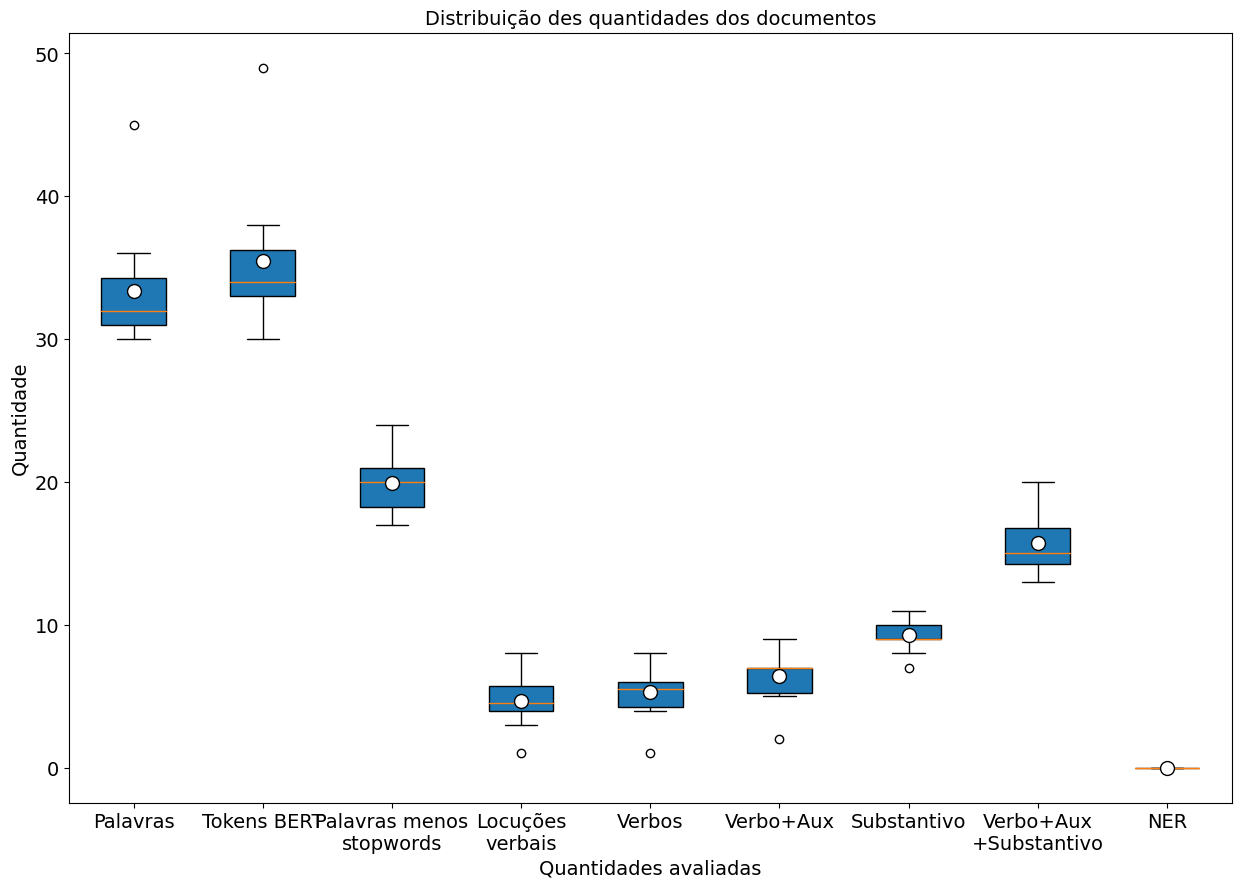

In [59]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades dos documentos")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_documentos], 
           [x["qtdetokensbert"] for x in stats_documentos],
           [x["qtdepalavrassemstopword"] for x in stats_documentos],
           [x["qtdelocverbo"] for x in stats_documentos],
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           [x["qtdener"] for x in stats_documentos],
           ]

# Estrutura do gráfico
bplot1 = ax.boxplot(colunas, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
rotulos = ["Palavras", 
           "Tokens BERT", 
           "Palavras menos\nstopwords", 
           "Locuções\nverbais", 
           "Verbos",
           "Verbo+Aux", 
           "Substantivo", 
           "Verbo+Aux\n+Substantivo",
           "NER"]
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, rotulos)

# Mostra o gráfico
plt.show()

#### 5.2.3.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [60]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
dfstats_documentos_dic_pos = pd.DataFrame([getSomaDic(x[1]) for x in stats_documentos_dic_pos])

# Exibe as estatísticas
dfstats_documentos_dic_pos.describe(include="all")

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.0,10.00,10.0,10.0,10.0
mean,2.20,5.30,3.00,3.20,9.30,1.10,1.50,3.30,0.10,3.00,0.20,0.0,1.20,0.0,0.0,0.0
std,0.92,2.06,1.33,1.69,1.25,0.32,0.71,1.34,0.32,0.94,0.42,0.0,0.92,0.0,0.0,0.0
min,1.00,1.00,1.00,2.00,7.00,1.00,1.00,1.00,0.00,2.00,0.00,0.0,0.00,0.0,0.0,0.0
25%,2.00,4.25,2.25,2.00,9.00,1.00,1.00,2.25,0.00,2.25,0.00,0.0,1.00,0.0,0.0,0.0
50%,2.00,5.50,3.00,2.50,9.00,1.00,1.00,3.50,0.00,3.00,0.00,0.0,1.00,0.0,0.0,0.0
75%,2.75,6.00,3.00,3.75,10.00,1.00,2.00,4.00,0.00,3.00,0.00,0.0,1.75,0.0,0.0,0.0
max,4.00,8.00,6.00,7.00,11.00,2.00,3.00,5.00,1.00,5.00,1.00,0.0,3.00,0.0,0.0,0.0


Organiza os dados para gerar o boxplot

In [61]:
# Converte os dados para o boxplot
lista_dic_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_documentos_dic_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic(x[1])      
    for chave, valor in posx.items():
        lista_dic_postagging.append([x[0], chave, valor])

# Converte em um dataframe
dfstats_documentos_dic_pos = pd.DataFrame(lista_dic_postagging, columns=("id", "pos", "qtde")) 

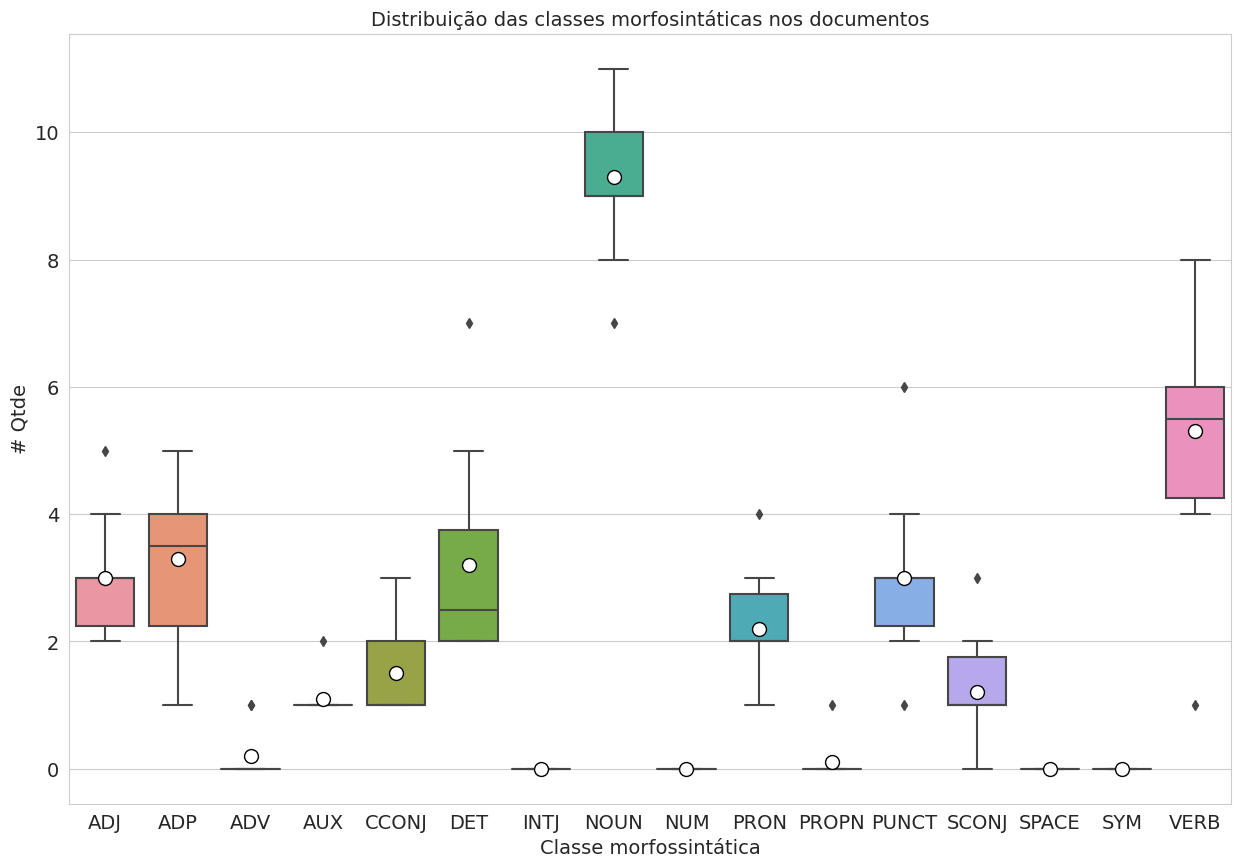

In [62]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(dfstats_documentos_dic_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = dfstats_documentos_dic_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de POS Tagging nos documentos

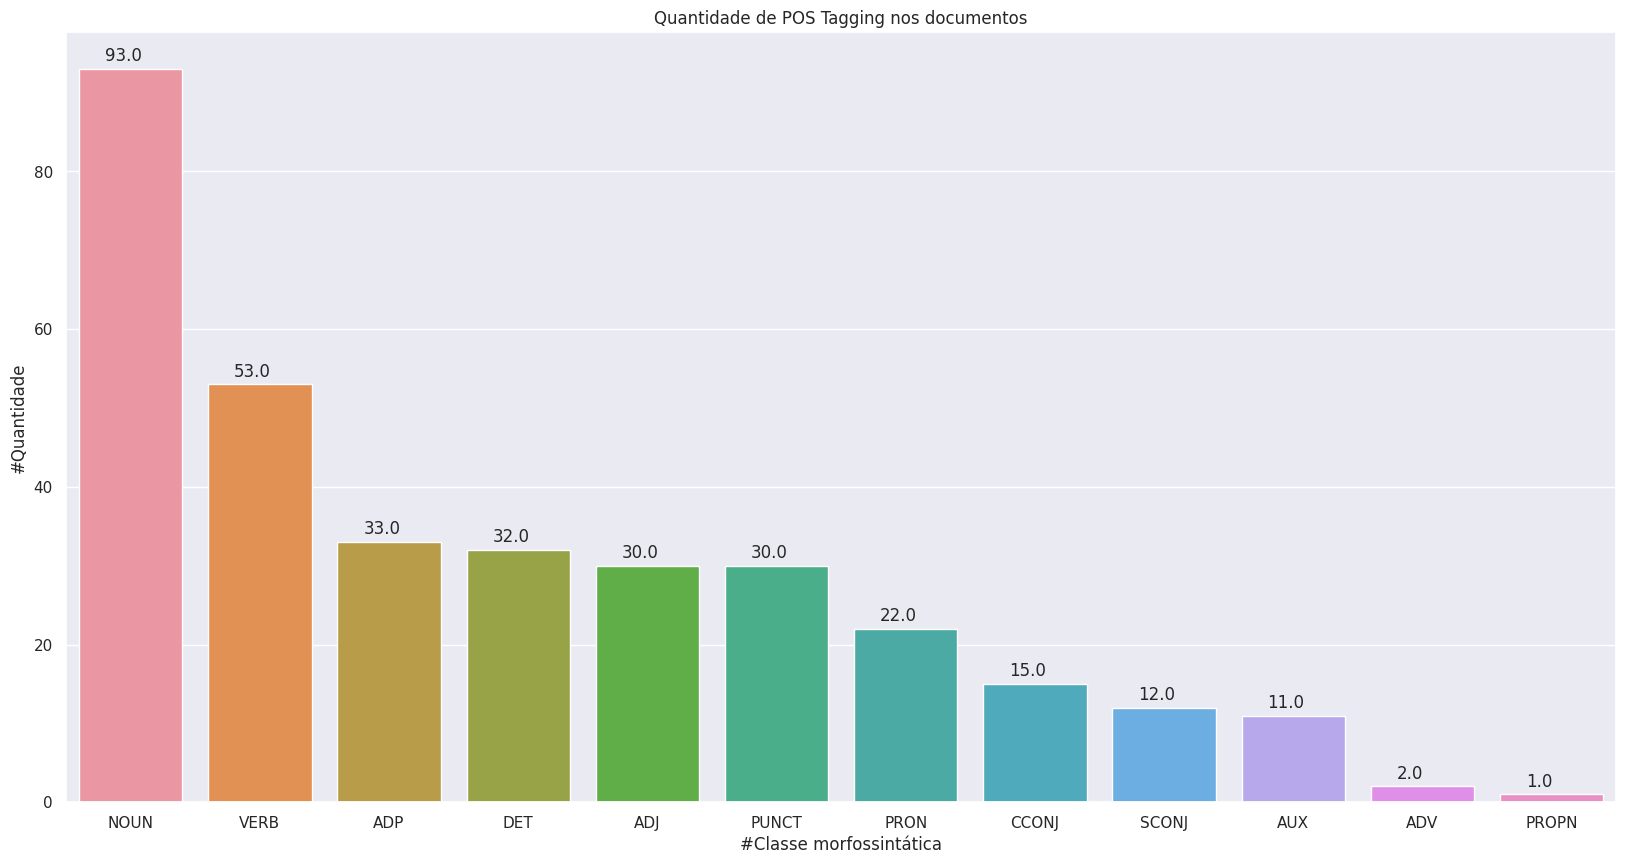

In [63]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Lista em ordem crescente os dados
order = dfstats_documentos_pos['pos'].value_counts(ascending=False).index

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="pos", data = dfstats_documentos_pos, order=order)

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de POS Tagging nos documentos")
plt.xlabel("#Classe morfossintática")
plt.ylabel("#Quantidade")

plt.show()

#### 5.2.3.3 NER

In [64]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
dfstats_documentos_dic_ner = pd.DataFrame([getSomaDic(x[1]) for x in stats_documentos_dic_ner])

# Exibe as estatísticas
dfstats_documentos_dic_ner.describe(include="all")

,LOC,MISC,ORG,PER
count,10.0,10.0,10.0,10.0
mean,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0


Organiza os dados para gerar o boxplot

In [65]:
# Converte os dados para o boxplot
lista_dic_ner = []
# Percorre as estatísticas ner dos documentos
for x in stats_documentos_dic_ner:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic(x[1])      
    for chave, valor in posx.items():
        lista_dic_ner.append([x[0], chave, valor])

# Converte em um dataframe
dfstats_documentos_dic_ner = pd.DataFrame(lista_dic_ner, columns=("id", "ner", "qtde")) 

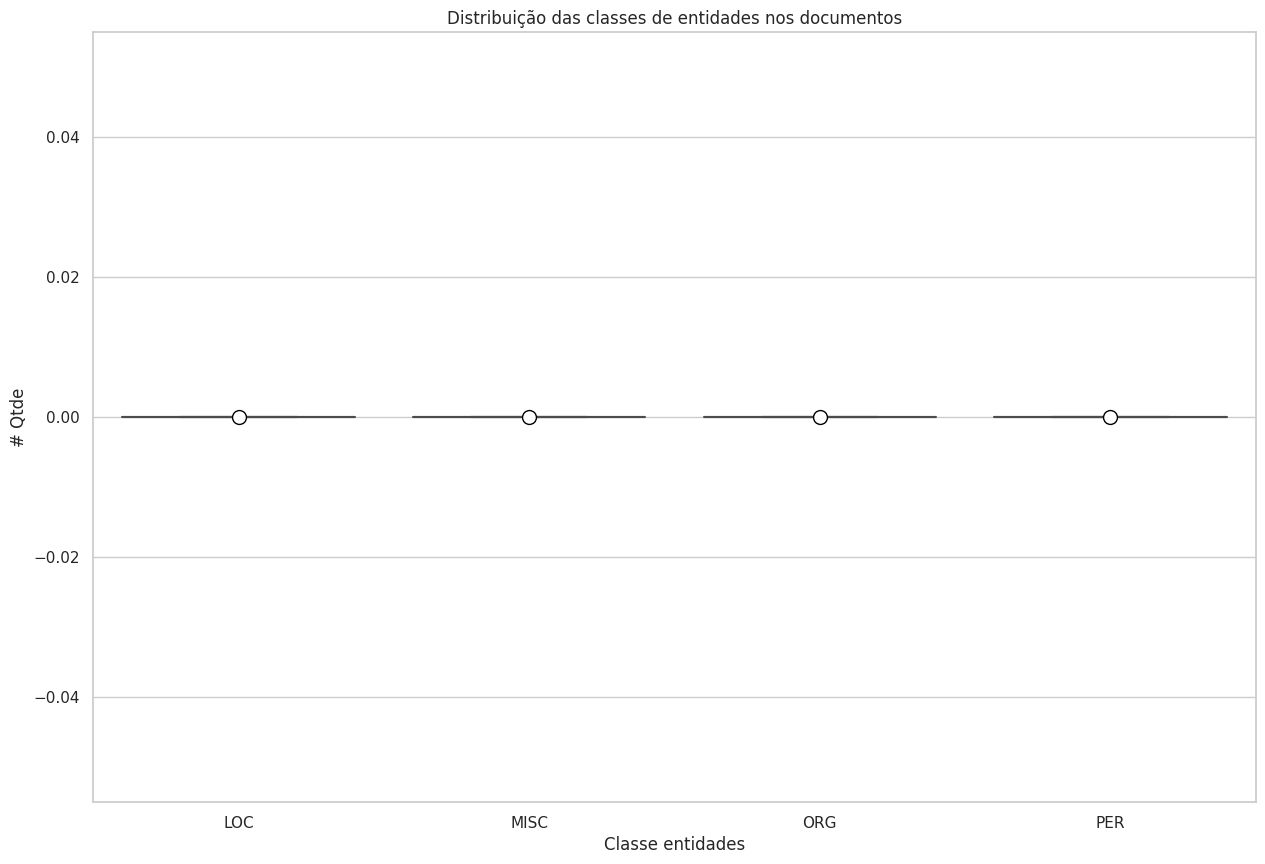

In [66]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(dfstats_documentos_dic_ner['ner'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "ner", y = "qtde", data = dfstats_documentos_dic_ner, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes de entidades nos documentos")
# Texto do eixo x
plt.xlabel("Classe entidades")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de NER nos documentos

In [67]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Lista em ordem crescente os dados
order = dfstats_documentos_ner['classe'].value_counts(ascending=False).index

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="classe", data = dfstats_documentos_ner, order=order)

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de entidades nos documentos")
plt.xlabel("#Classe entidade")
plt.ylabel("#Quantidade")

plt.show()

ValueError: ignored

#### 5.2.3.4 Lista palavras

Lista as 20 palavras com maiores ocorrências no conjunto de dados.

In [68]:
for i, valor in enumerate(sorted(dicionario_palavras, key = dicionario_palavras.get, reverse=True)):
  if i < 20:
    print(valor, "=>", dicionario_palavras[valor])  

que => 21
, => 20
de => 17
e => 15
inteligência => 12
A => 10
artificial => 10
é => 10
. => 10
da => 8
tarefas => 7
uma => 5
um => 5
ciência => 4
computação => 4
se => 4
algoritmos => 4
sistemas => 4
realizar => 4
humana => 4


#### 5.2.3.5 Lista palavras desconhecidas e ocorrências

Lista as 20 palavras desconhecidas pelo BERT com maiores ocorrência.

In [69]:
lista_palavras_desconhecidas_ocorrencias = []

for palavra in sorted(list(dict.fromkeys([x[0] for x in lista_palavras_desconhecidas_geral]))):
  conta = 0  
  tokenizada = ""
  for x in sorted(lista_palavras_desconhecidas_geral, key = lambda x: x[0]):
    if x[0] == palavra:
      conta = conta + 1
      tokenizada = x[1]
  #print(palavra, "=>", tokenizada, "=>", conta)
  lista_palavras_desconhecidas_ocorrencias.append([palavra, tokenizada, conta])
  
for i, palavra in enumerate(sorted(lista_palavras_desconhecidas_ocorrencias, key = lambda x: x[2], reverse=True)):
  if i < 20:
     print(palavra[0], "=>", palavra[1], "=>", palavra[2])

raciocinar => ['racioc', '##inar'] => 2
realizem => ['realiz', '##em'] => 2
aprendam => ['aprend', '##am'] => 1
cognitivas => ['cogni', '##tivas'] => 1
comunicam => ['comunica', '##m'] => 1
divertem => ['diver', '##tem'] => 1
exigiriam => ['exigir', '##iam'] => 1
informadas => ['informa', '##das'] => 1
interagir => ['interag', '##ir'] => 1
interdisciplinar => ['inter', '##dis', '##ciplinar'] => 1
melhorem => ['melhor', '##em'] => 1
neurais => ['neur', '##ais'] => 1
neurociência => ['neuro', '##ciência'] => 1
processem => ['process', '##em'] => 1
resolvam => ['resol', '##vam'] => 1
simulem => ['simul', '##em'] => 1
sofisticadas => ['sofistic', '##adas'] => 1
tomem => ['tom', '##em'] => 1


### 5.2.4 Por sentença

#### 5.2.4.1 Gerais

In [70]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_sentencas)

df_stats.describe(include="all")

,id,sentenca,qtdepalavras,qtdetokensbert,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverboauxsubstantivo,qtdepalavrasdesconhecidas,qtdener
count,10.00,10.0,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.0
mean,5.50,0.0,33.40,35.50,19.90,4.70,5.30,6.40,9.30,15.70,2.00,0.0
std,3.03,0.0,4.53,5.23,2.02,2.00,2.06,2.07,1.25,2.11,1.25,0.0
min,1.00,0.0,30.00,30.00,17.00,1.00,1.00,2.00,7.00,13.00,0.00,0.0
25%,3.25,0.0,31.00,33.00,18.25,4.00,4.25,5.25,9.00,14.25,1.00,0.0
50%,5.50,0.0,32.00,34.00,20.00,4.50,5.50,7.00,9.00,15.00,2.00,0.0
75%,7.75,0.0,34.25,36.25,21.00,5.75,6.00,7.00,10.00,16.75,3.00,0.0
max,10.00,0.0,45.00,49.00,24.00,8.00,8.00,9.00,11.00,20.00,4.00,0.0


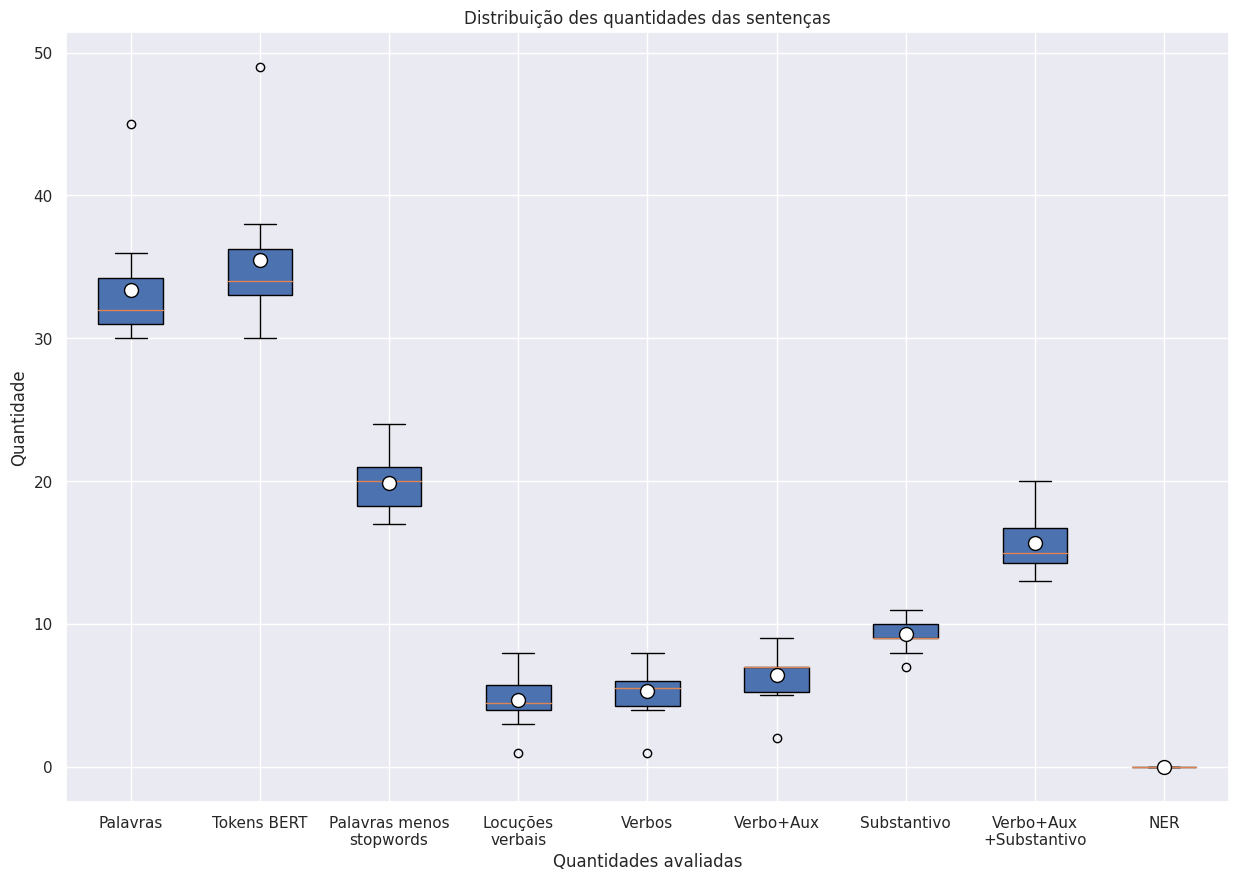

In [71]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades das sentenças")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

rotulos = [[x["qtdepalavras"] for x in stats_sentencas], 
           [x["qtdetokensbert"] for x in stats_sentencas],
           [x["qtdepalavrassemstopword"] for x in stats_sentencas],
           [x["qtdelocverbo"] for x in stats_sentencas],
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           [x["qtdener"] for x in stats_sentencas],
           ]

# Estrutura do gráfico
ax.boxplot(rotulos, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, ["Palavras", 
                     "Tokens BERT", 
                     "Palavras menos\nstopwords", 
                     "Locuções\nverbais", 
                     "Verbos",
                     "Verbo+Aux", 
                     "Substantivo", 
                     "Verbo+Aux\n+Substantivo",
                     "NER"])

# Mostra o gráfico
plt.show()

#### 5.2.4.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [72]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
df_stats_sentencas_dic_pos = pd.DataFrame([getSomaDic([x[2]]) for x in stats_sentencas_dic_pos])

# Exibe as estatísticas
df_stats_sentencas_dic_pos.describe()

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.0,10.00,10.0,10.0,10.0
mean,2.20,5.30,3.00,3.20,9.30,1.10,1.50,3.30,0.10,3.00,0.20,0.0,1.20,0.0,0.0,0.0
std,0.92,2.06,1.33,1.69,1.25,0.32,0.71,1.34,0.32,0.94,0.42,0.0,0.92,0.0,0.0,0.0
min,1.00,1.00,1.00,2.00,7.00,1.00,1.00,1.00,0.00,2.00,0.00,0.0,0.00,0.0,0.0,0.0
25%,2.00,4.25,2.25,2.00,9.00,1.00,1.00,2.25,0.00,2.25,0.00,0.0,1.00,0.0,0.0,0.0
50%,2.00,5.50,3.00,2.50,9.00,1.00,1.00,3.50,0.00,3.00,0.00,0.0,1.00,0.0,0.0,0.0
75%,2.75,6.00,3.00,3.75,10.00,1.00,2.00,4.00,0.00,3.00,0.00,0.0,1.75,0.0,0.0,0.0
max,4.00,8.00,6.00,7.00,11.00,2.00,3.00,5.00,1.00,5.00,1.00,0.0,3.00,0.0,0.0,0.0


In [73]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_sentencas_dic_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic([x[2]])      
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_sentencas_dic_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde")) 

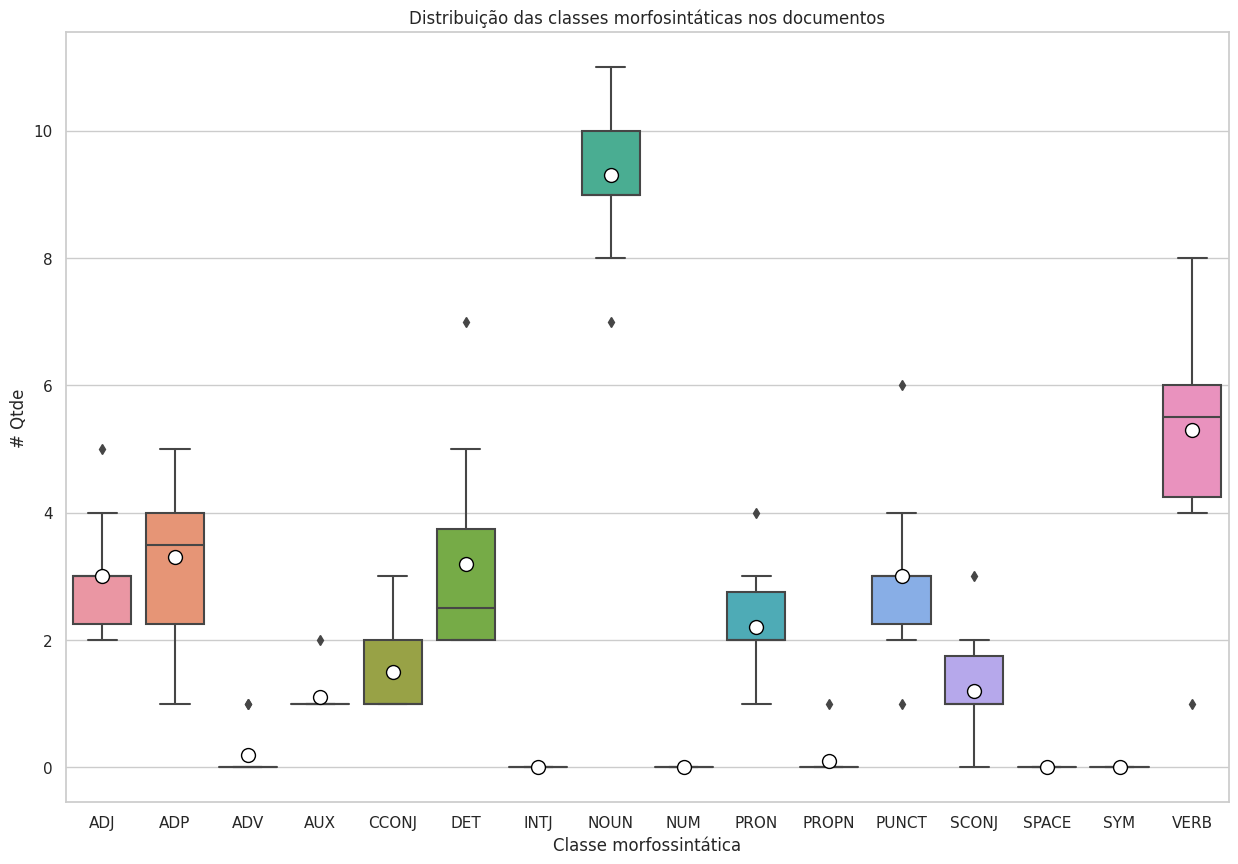

In [74]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_sentencas_dic_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_sentencas_dic_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de ocorrências de classes morfossintática por sentença

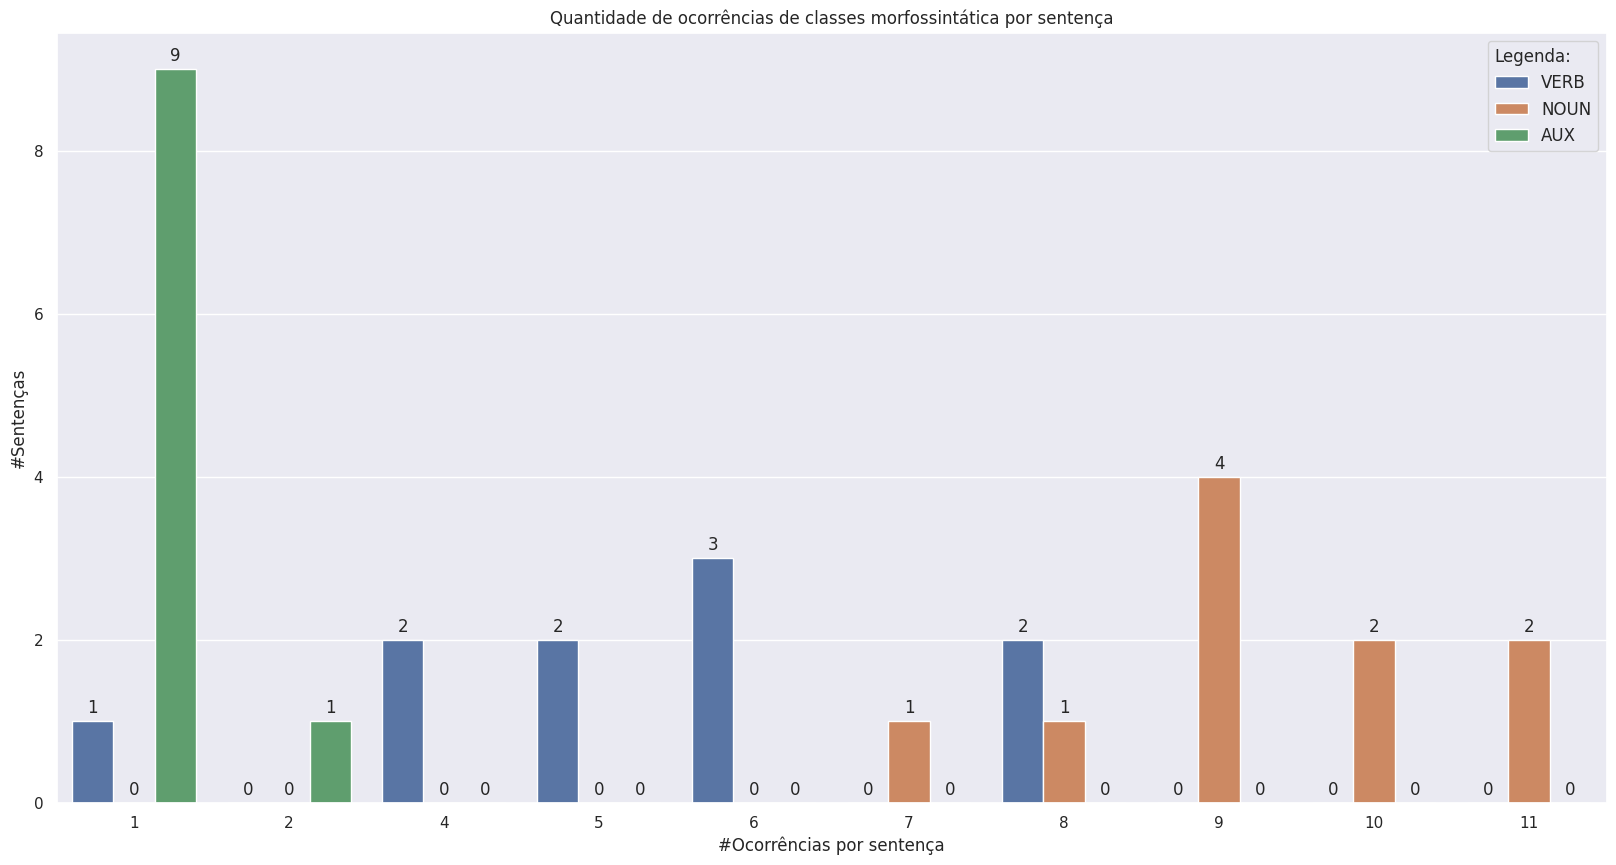

In [75]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

df_pos = df_stats_sentencas_dic_pos[df_stats_sentencas_dic_pos["pos"].isin(["NOUN","VERB","AUX"])]

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="qtde",hue="pos"  ,data=df_pos)

# Adiciona os valores as colunas
for p in ax.patches:    
    ax.annotate('{0:g}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))
    
plt.title("Quantidade de ocorrências de classes morfossintática por sentença")
plt.xlabel("#Ocorrências por sentença")
plt.ylabel("#Sentenças")

# Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
plt.legend(title='Legenda:', loc='upper right', fontsize=12)._legend_box.align='left'

plt.show()

Ex.: Existe 4(#Sentenças) sentenças onde palavras da classe morfossintática VERB(azul legenda) ocorrem uma vez(#Ocorrências por sentença).

#### 5.2.4.3 Gráficos de POS Tagging nas sentenças dos documentos

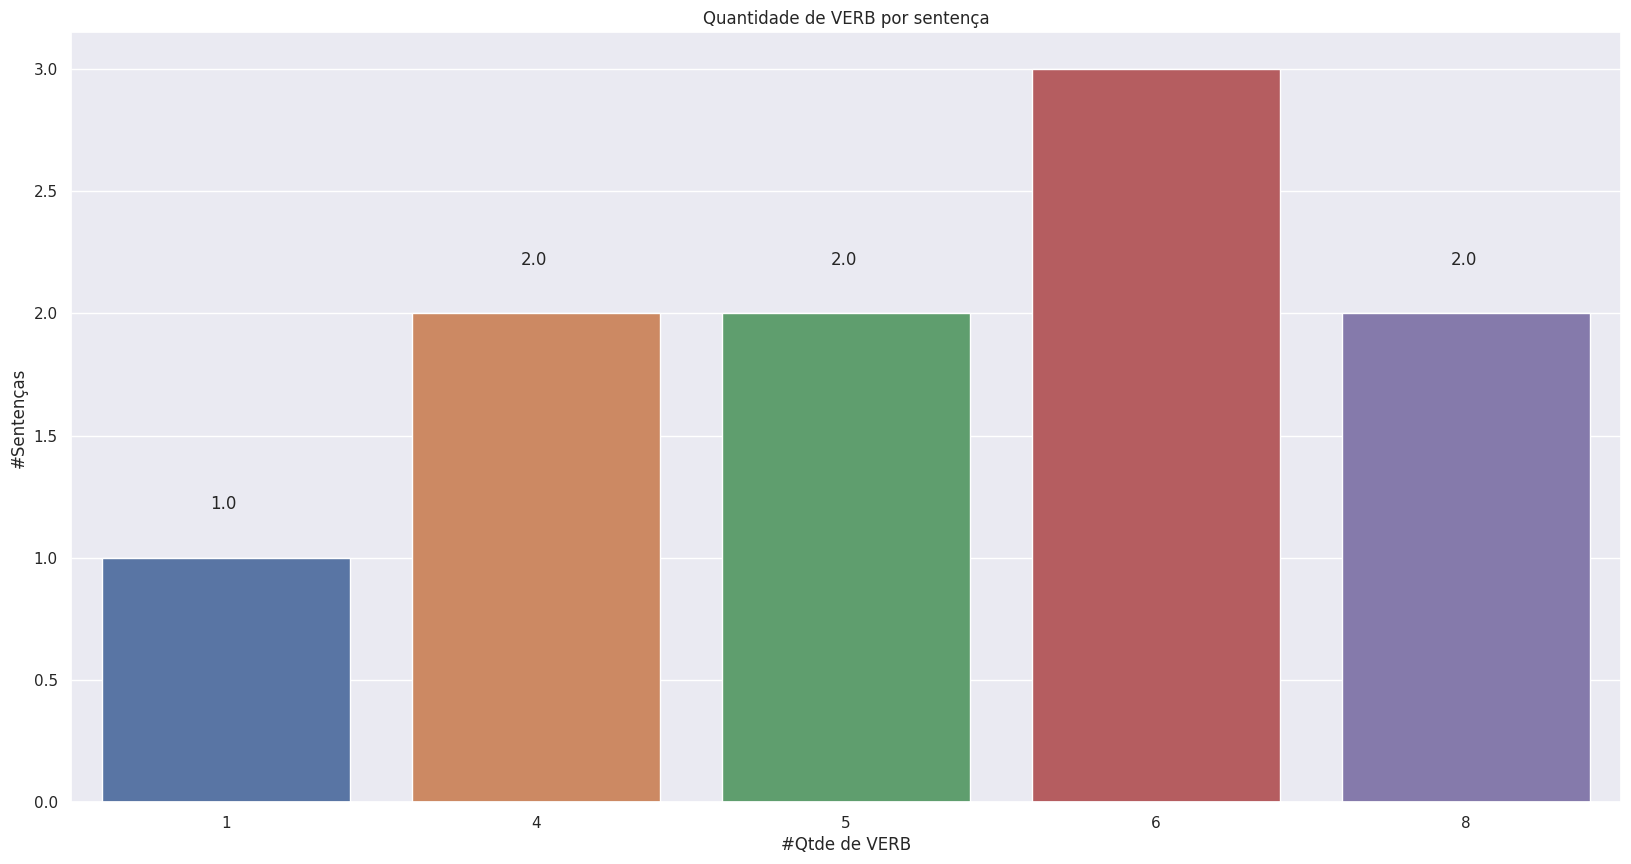

In [76]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="VERB"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.2))

plt.title("Quantidade de VERB por sentença")
plt.xlabel("#Qtde de VERB")
plt.ylabel("#Sentenças")

plt.show()

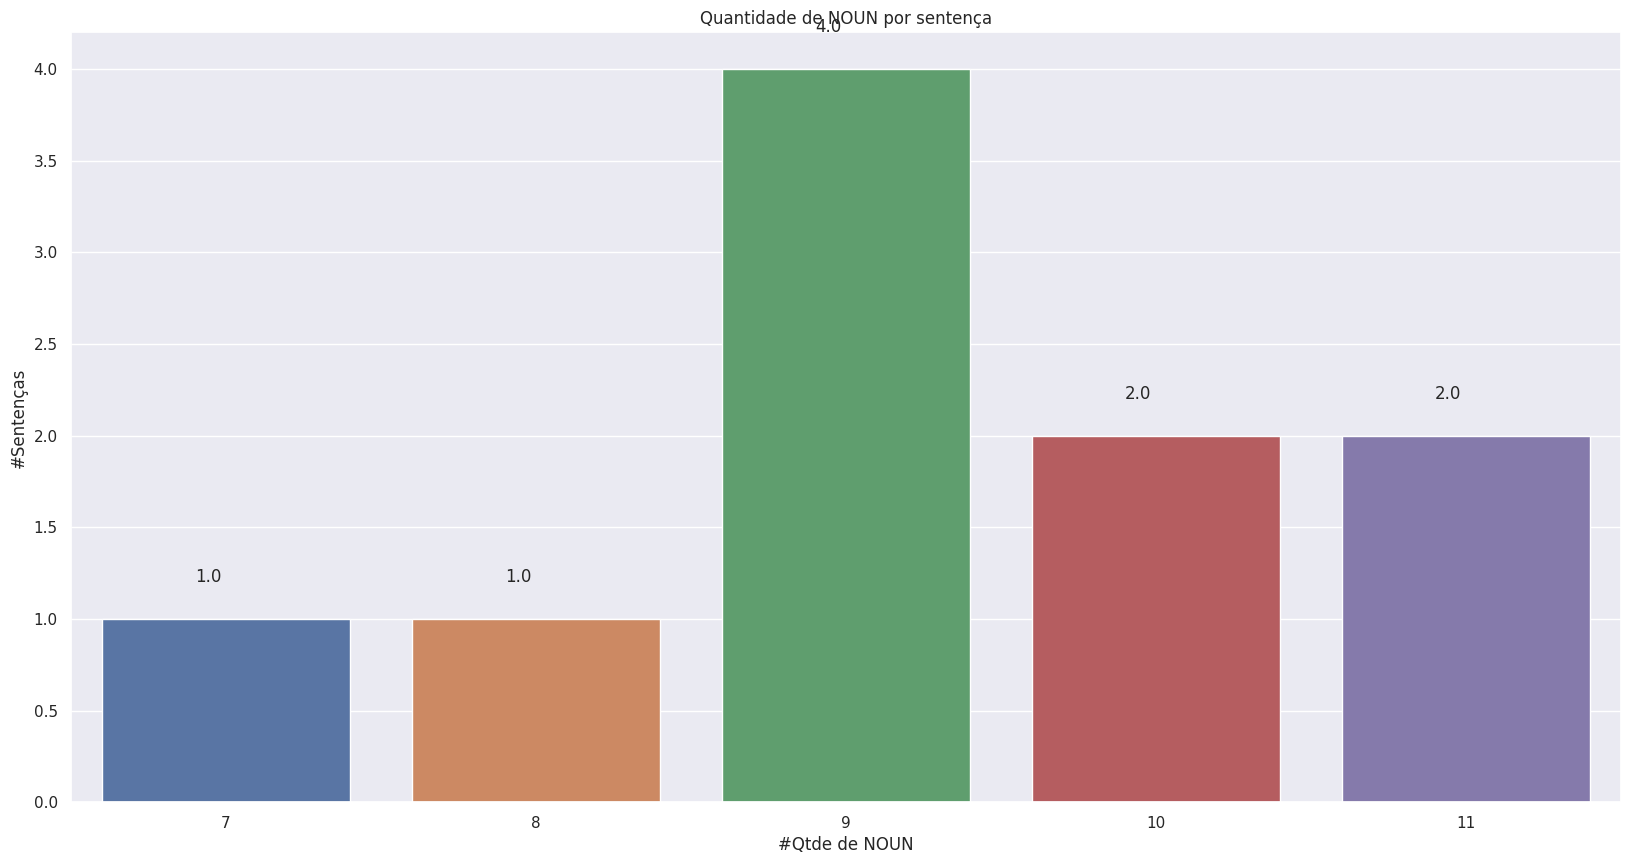

In [77]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="NOUN"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de NOUN por sentença")
plt.xlabel("#Qtde de NOUN")
plt.ylabel("#Sentenças")

plt.show()

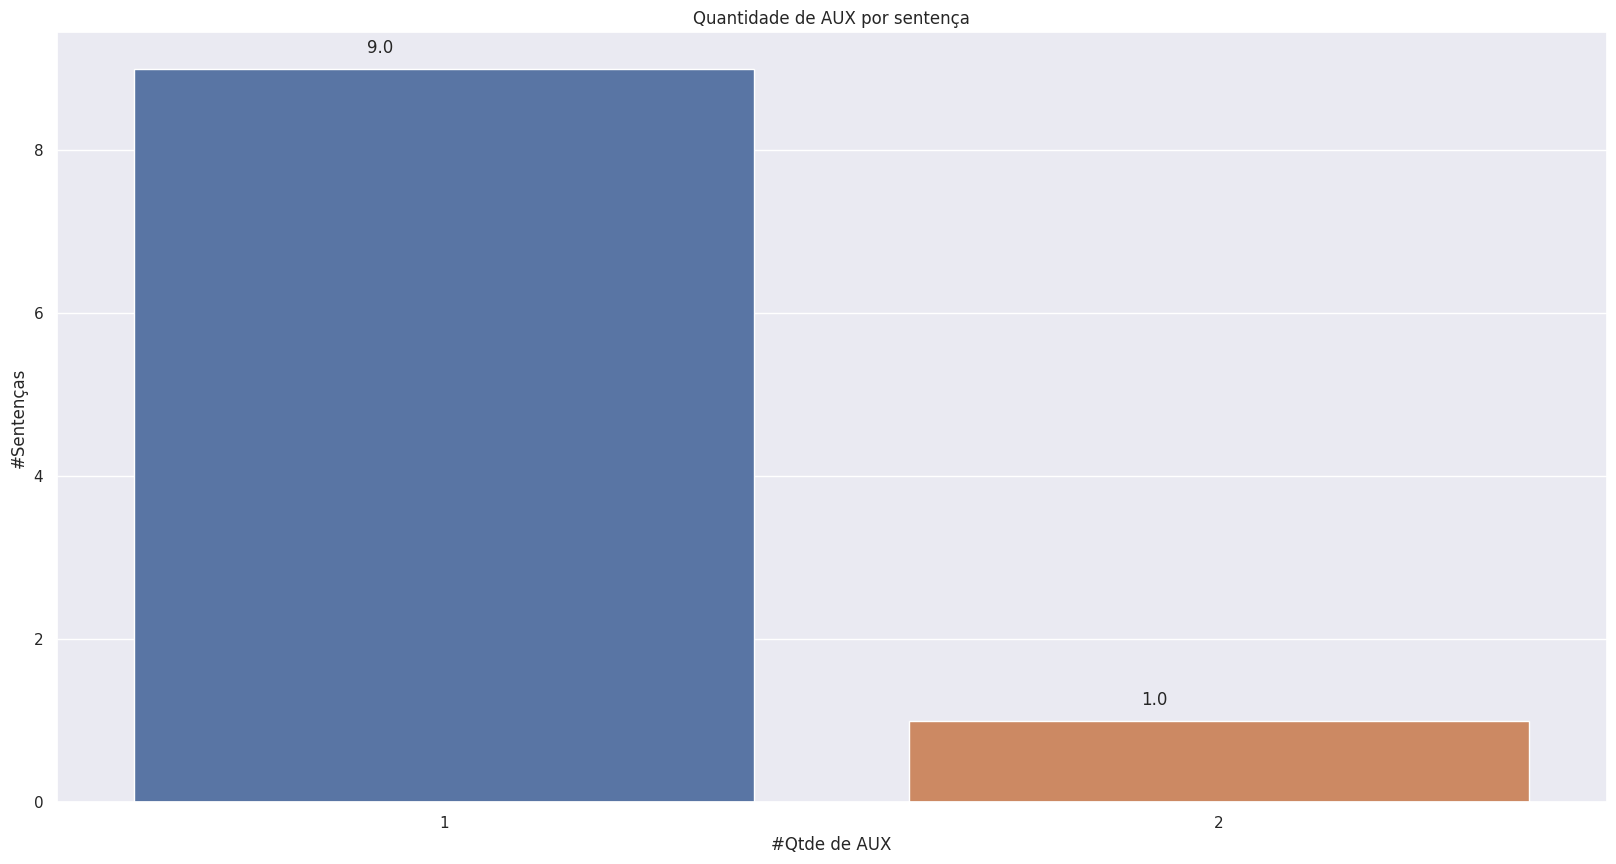

In [78]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="AUX"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de AUX por sentença")
plt.xlabel("#Qtde de AUX")
plt.ylabel("#Sentenças")

plt.show()

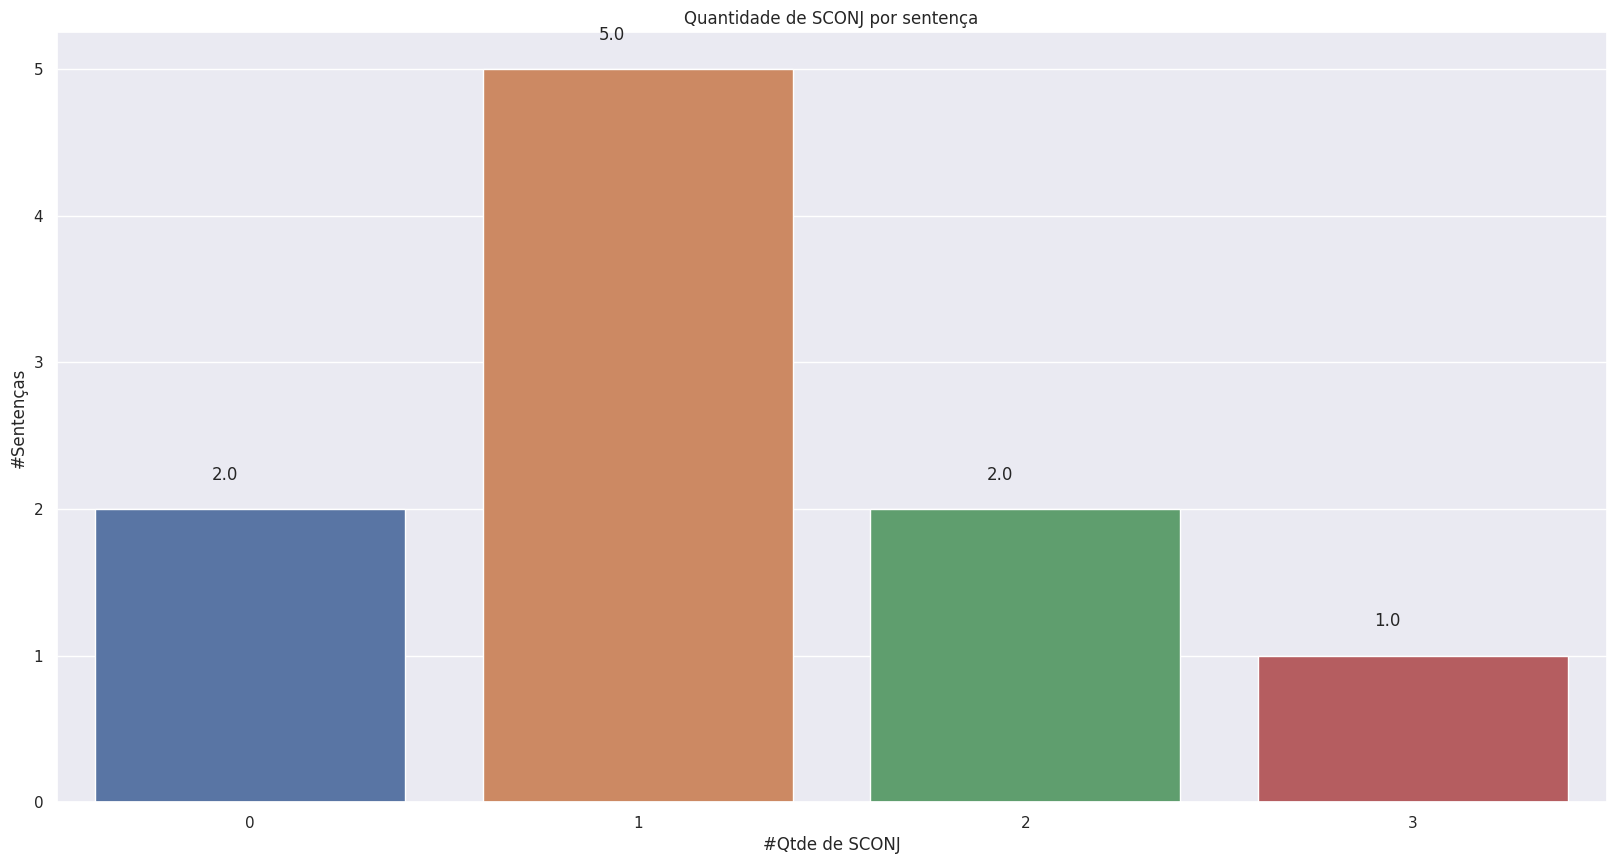

In [79]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="SCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de SCONJ por sentença")
plt.xlabel("#Qtde de SCONJ")
plt.ylabel("#Sentenças")

plt.show()

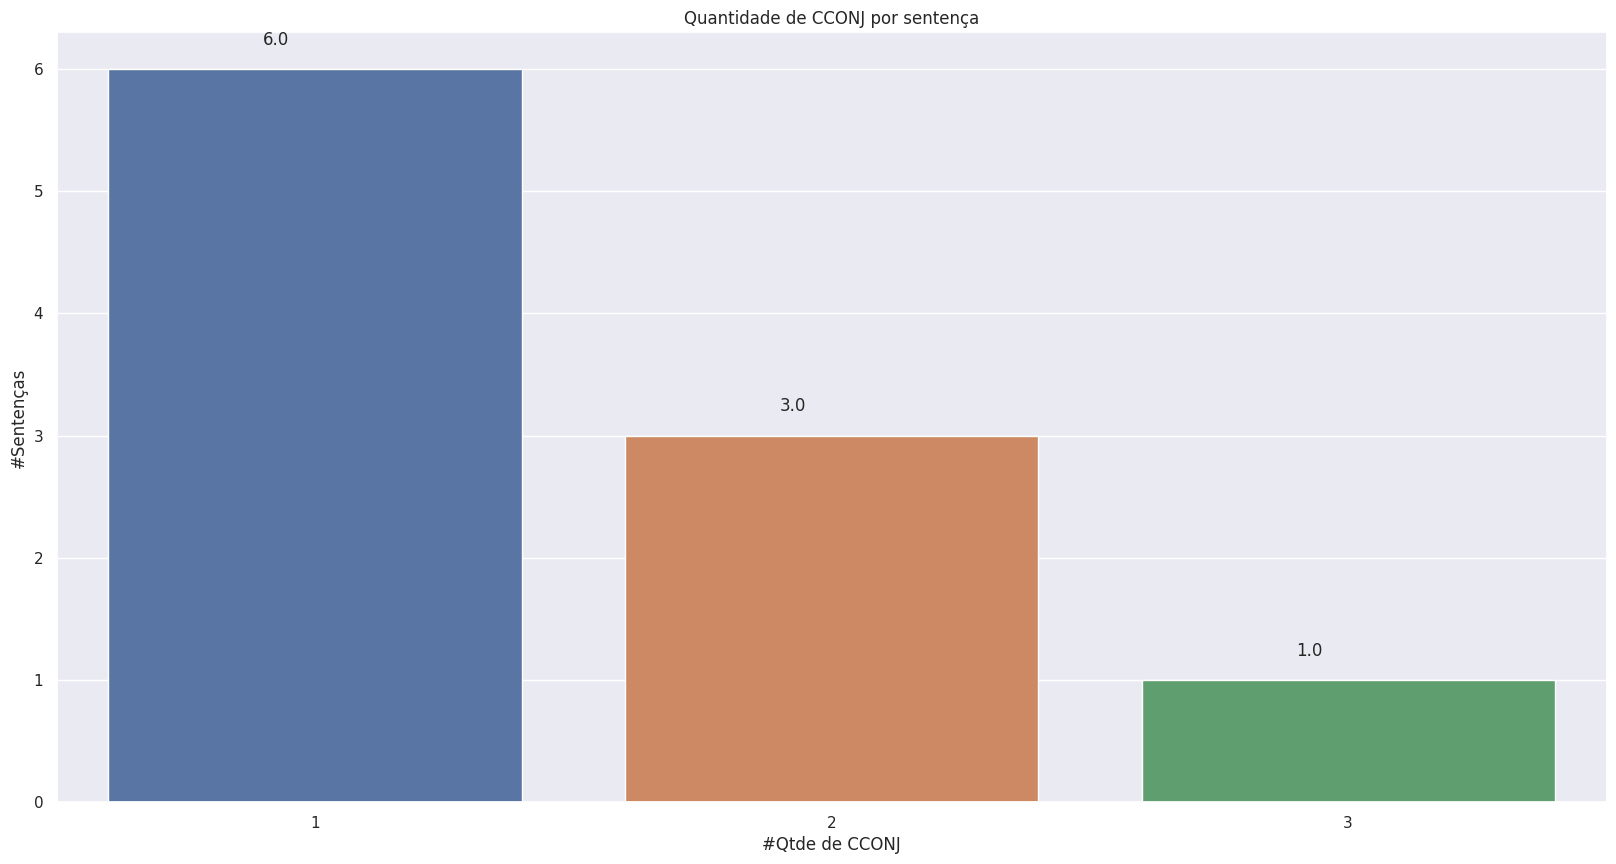

In [80]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="CCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de CCONJ por sentença")
plt.xlabel("#Qtde de CCONJ")
plt.ylabel("#Sentenças")

plt.show()

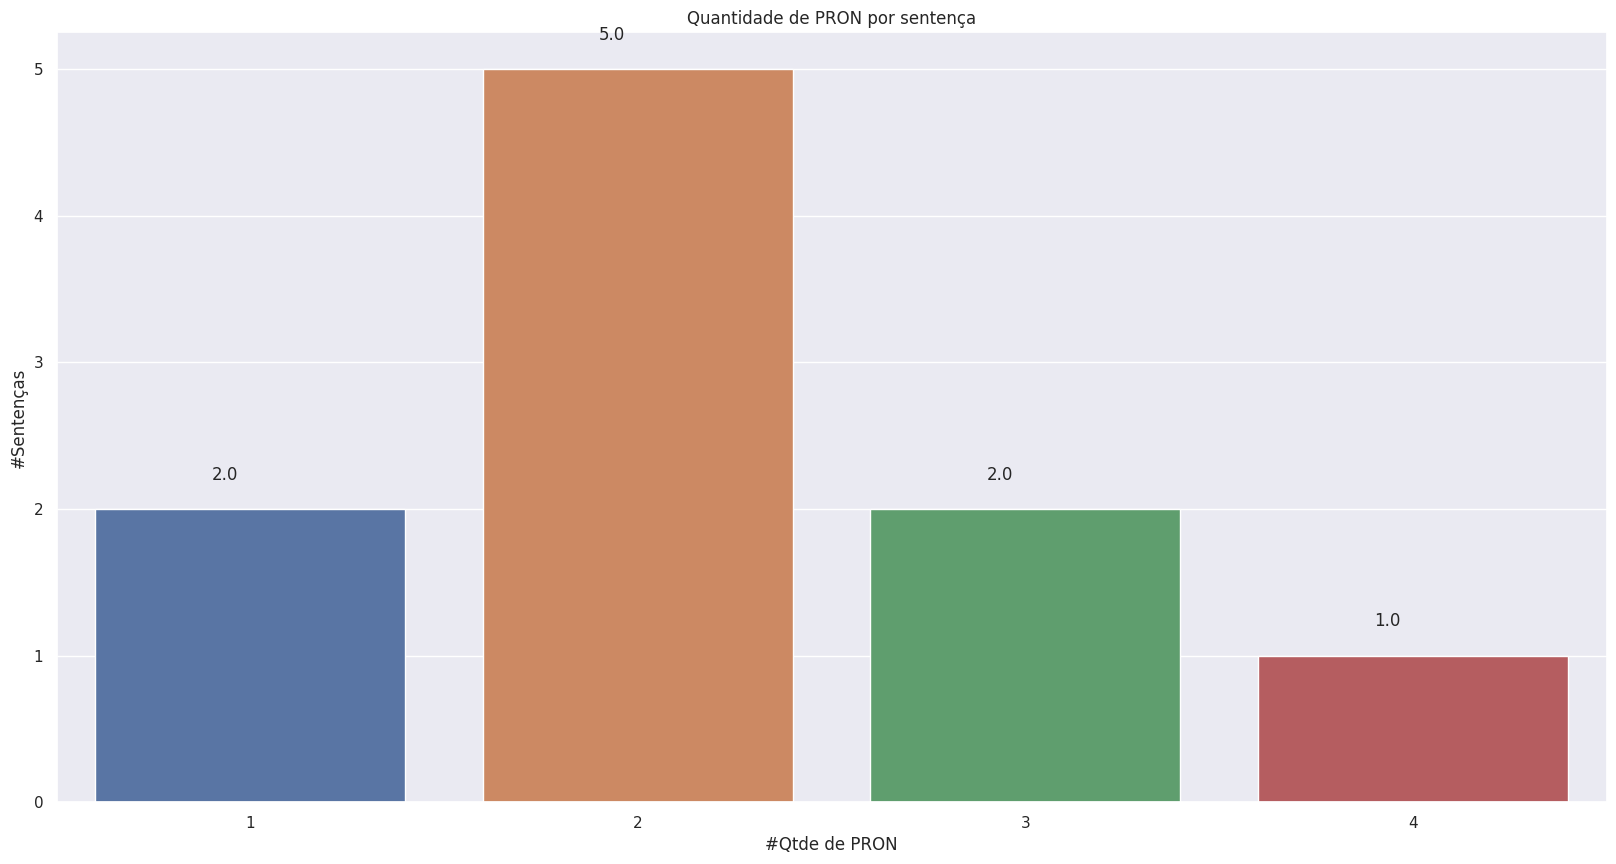

In [81]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="PRON"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de PRON por sentença")
plt.xlabel("#Qtde de PRON")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.4.4 NER

In [82]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
df_stats_sentencas_dic_ner = pd.DataFrame([getSomaDic([x[2]]) for x in stats_sentencas_dic_ner])

# Exibe as estatísticas
df_stats_sentencas_dic_ner.describe()

,LOC,MISC,ORG,PER
count,10.0,10.0,10.0,10.0
mean,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0


In [83]:
# Converte os dados para o boxplot
lista_ner = []
# Percorre as estatísticas pos dos documentos
for x in stats_sentencas_dic_ner:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic([x[2]])      
    for chave, valor in posx.items():
        lista_ner.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_sentencas_dic_ner = pd.DataFrame(lista_ner, columns=("id", "ner", "qtde")) 

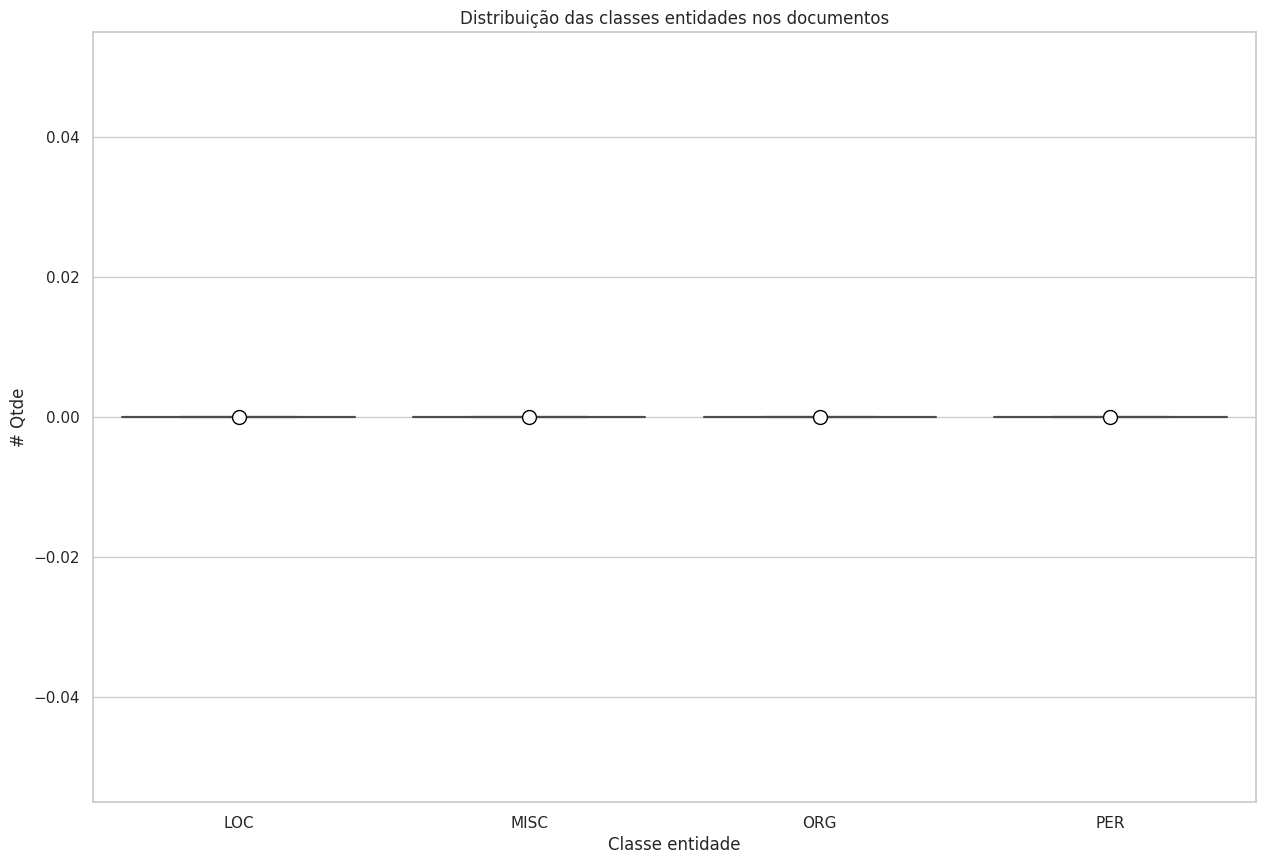

In [84]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_sentencas_dic_ner['ner'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "ner", y = "qtde", data = df_stats_sentencas_dic_ner, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes entidades nos documentos")
# Texto do eixo x
plt.xlabel("Classe entidade")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de ocorrências de classes entidades por sentença

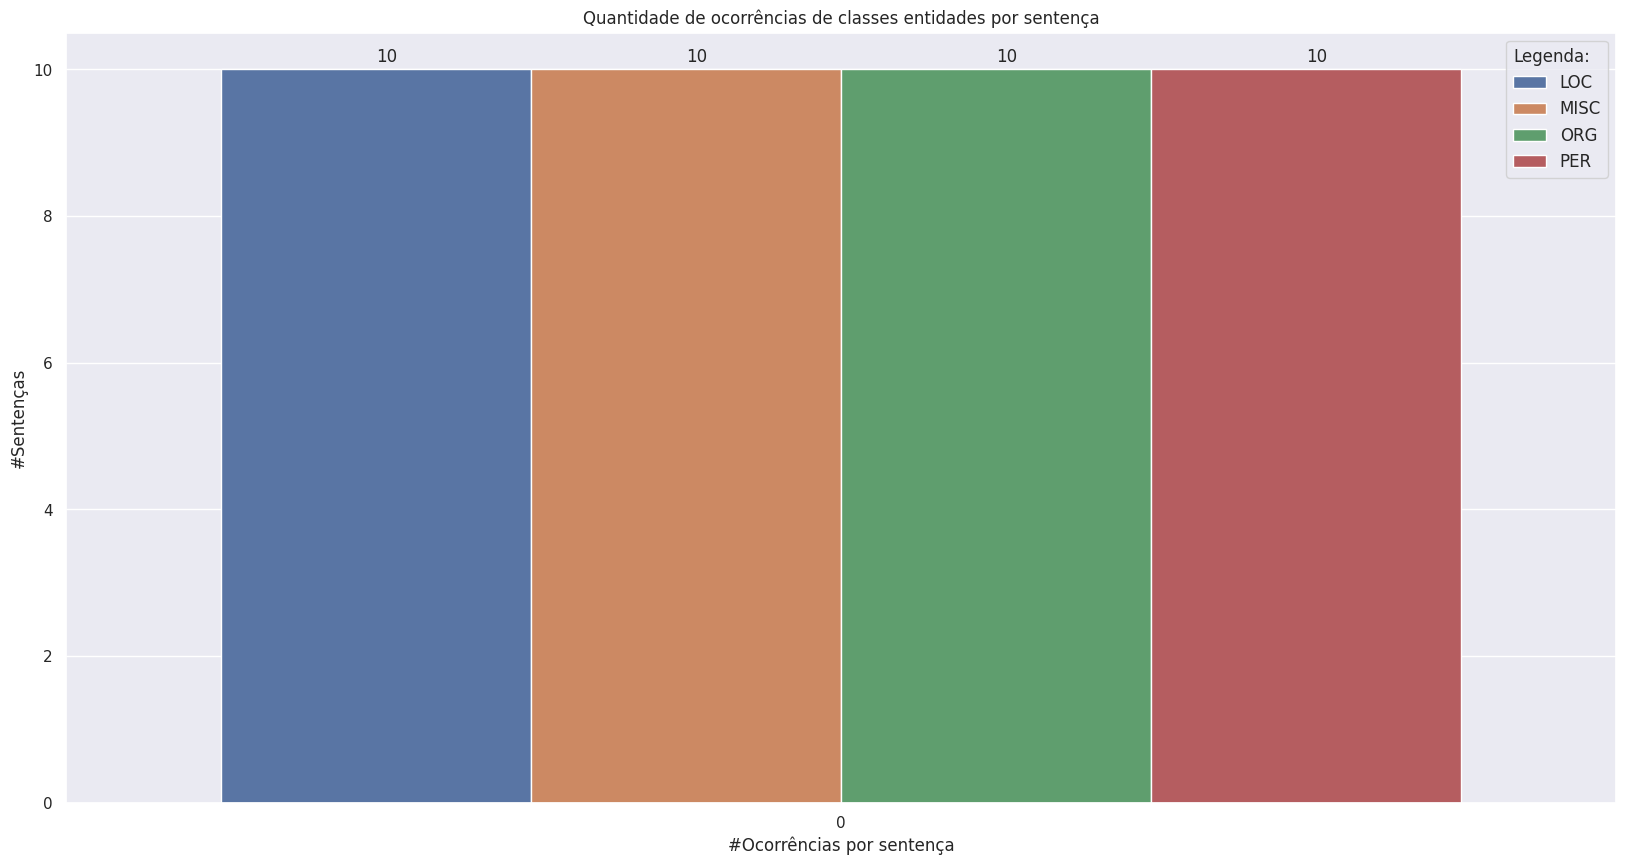

In [85]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

df_ner = df_stats_sentencas_dic_ner[df_stats_sentencas_dic_ner["ner"].isin(["LOC","MISC","ORG","PER"])]

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="qtde",hue="ner" ,data=df_ner)

# Adiciona os valores as colunas
for p in ax.patches:    
    ax.annotate('{0:g}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))
    
plt.title("Quantidade de ocorrências de classes entidades por sentença")
plt.xlabel("#Ocorrências por sentença")
plt.ylabel("#Sentenças")

# Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
plt.legend(title='Legenda:', loc='upper right', fontsize=12)._legend_box.align='left'

plt.show()

Ex.: Existe 4(#Sentenças) sentenças onde palavras da classe morfossintática LOC(azul legenda) ocorrem uma vez(#Ocorrências por sentença).

#### 5.2.4.5 Gráficos NER nas sentenças dos documentos 

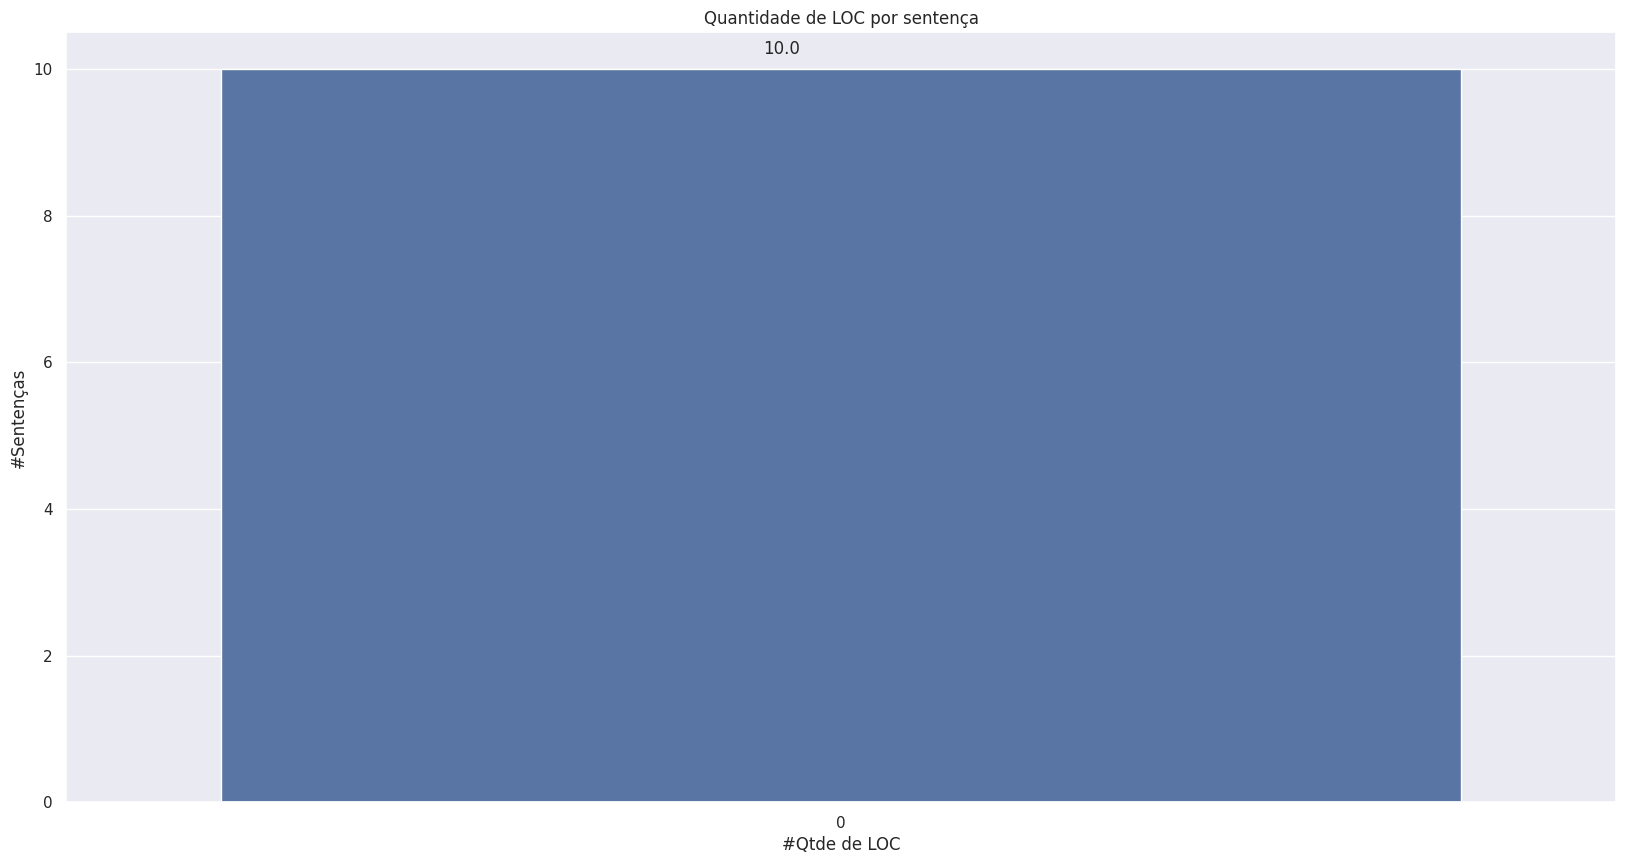

In [86]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_ner.iterrows() if f["ner"]=="LOC"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.2))

plt.title("Quantidade de LOC por sentença")
plt.xlabel("#Qtde de LOC")
plt.ylabel("#Sentenças")

plt.show()

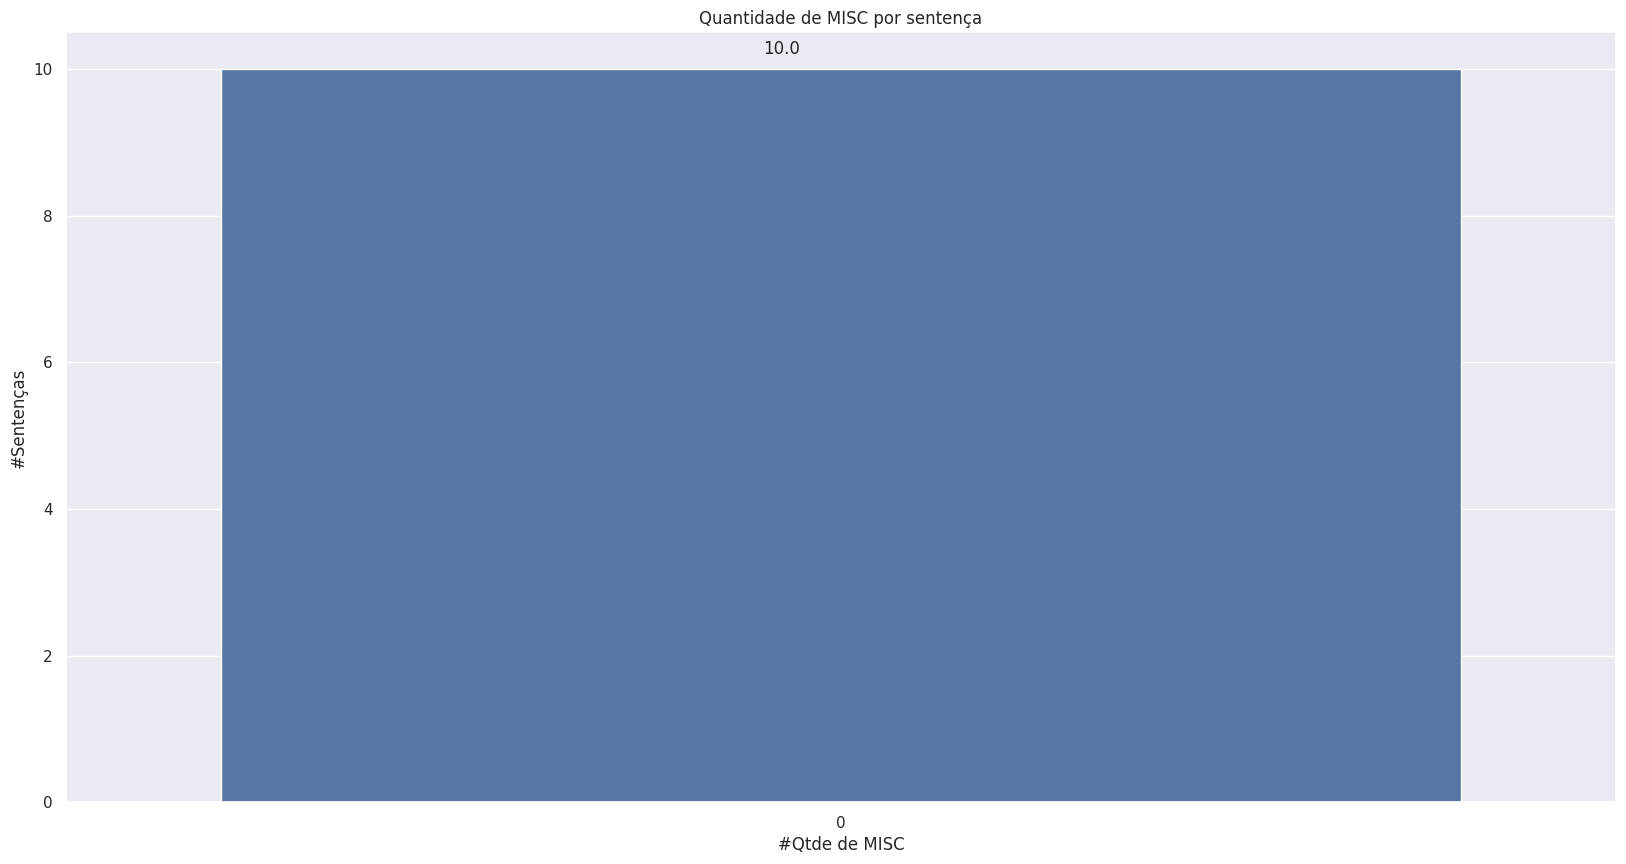

In [87]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_ner.iterrows() if f["ner"]=="MISC"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.2))

plt.title("Quantidade de MISC por sentença")
plt.xlabel("#Qtde de MISC")
plt.ylabel("#Sentenças")

plt.show()

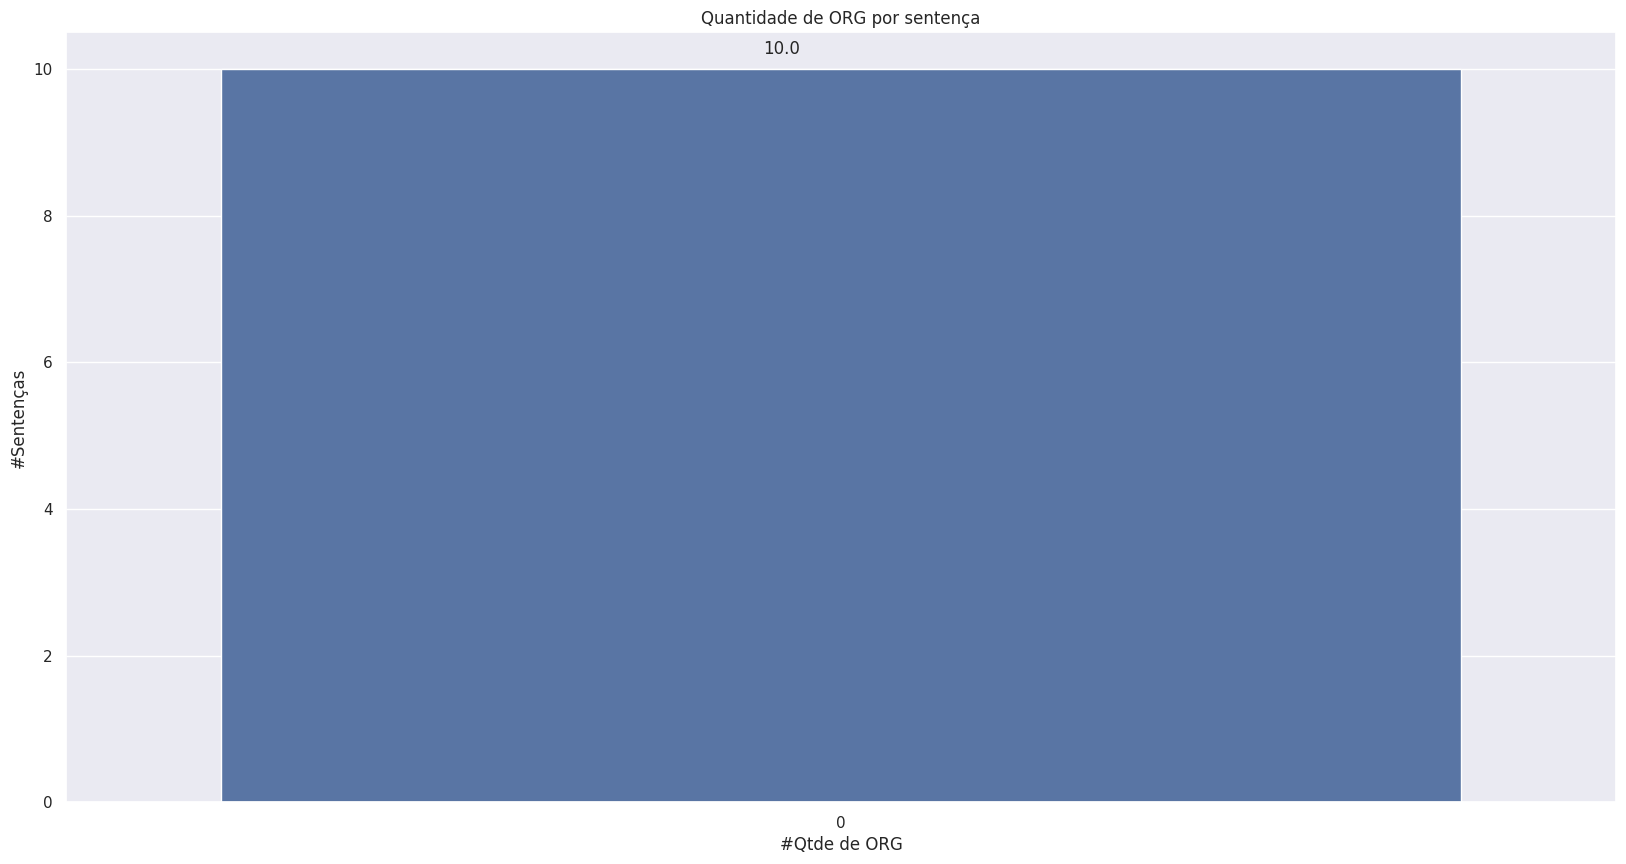

In [88]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_ner.iterrows() if f["ner"]=="ORG"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.2))

plt.title("Quantidade de ORG por sentença")
plt.xlabel("#Qtde de ORG")
plt.ylabel("#Sentenças")

plt.show()

### 5.2.5 Por Documento

#### 5.2.5.1 Gráfico Quantidade de documentos por quantidade de sentenças

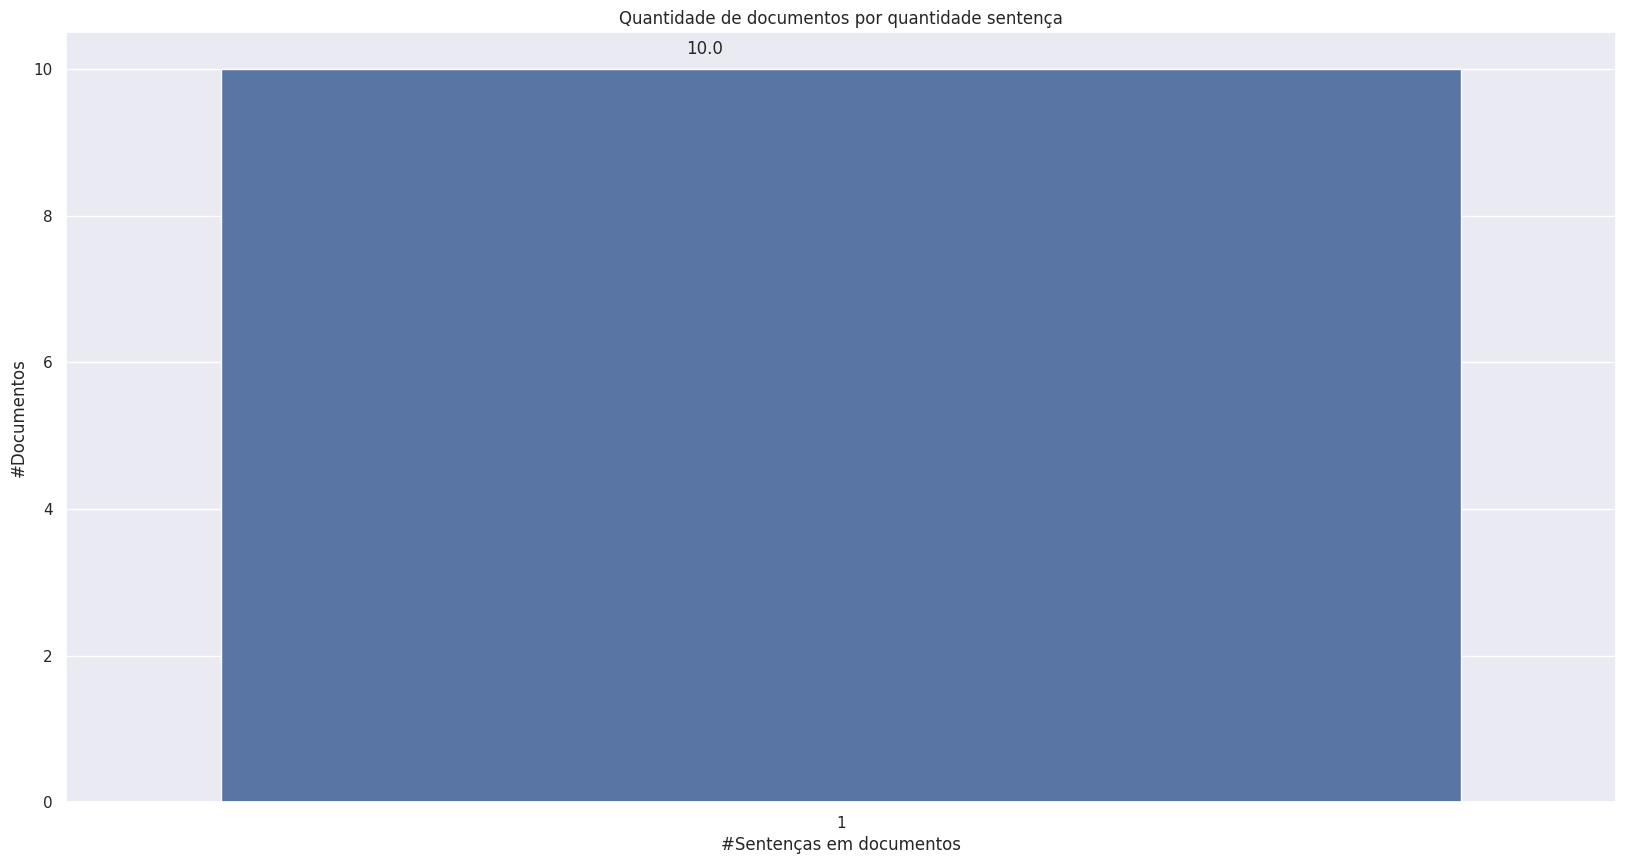

In [89]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesentencas"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de documentos por quantidade sentença")
plt.xlabel("#Sentenças em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.2 Gráfico Quantidade de documentos  por quantidade de palavras

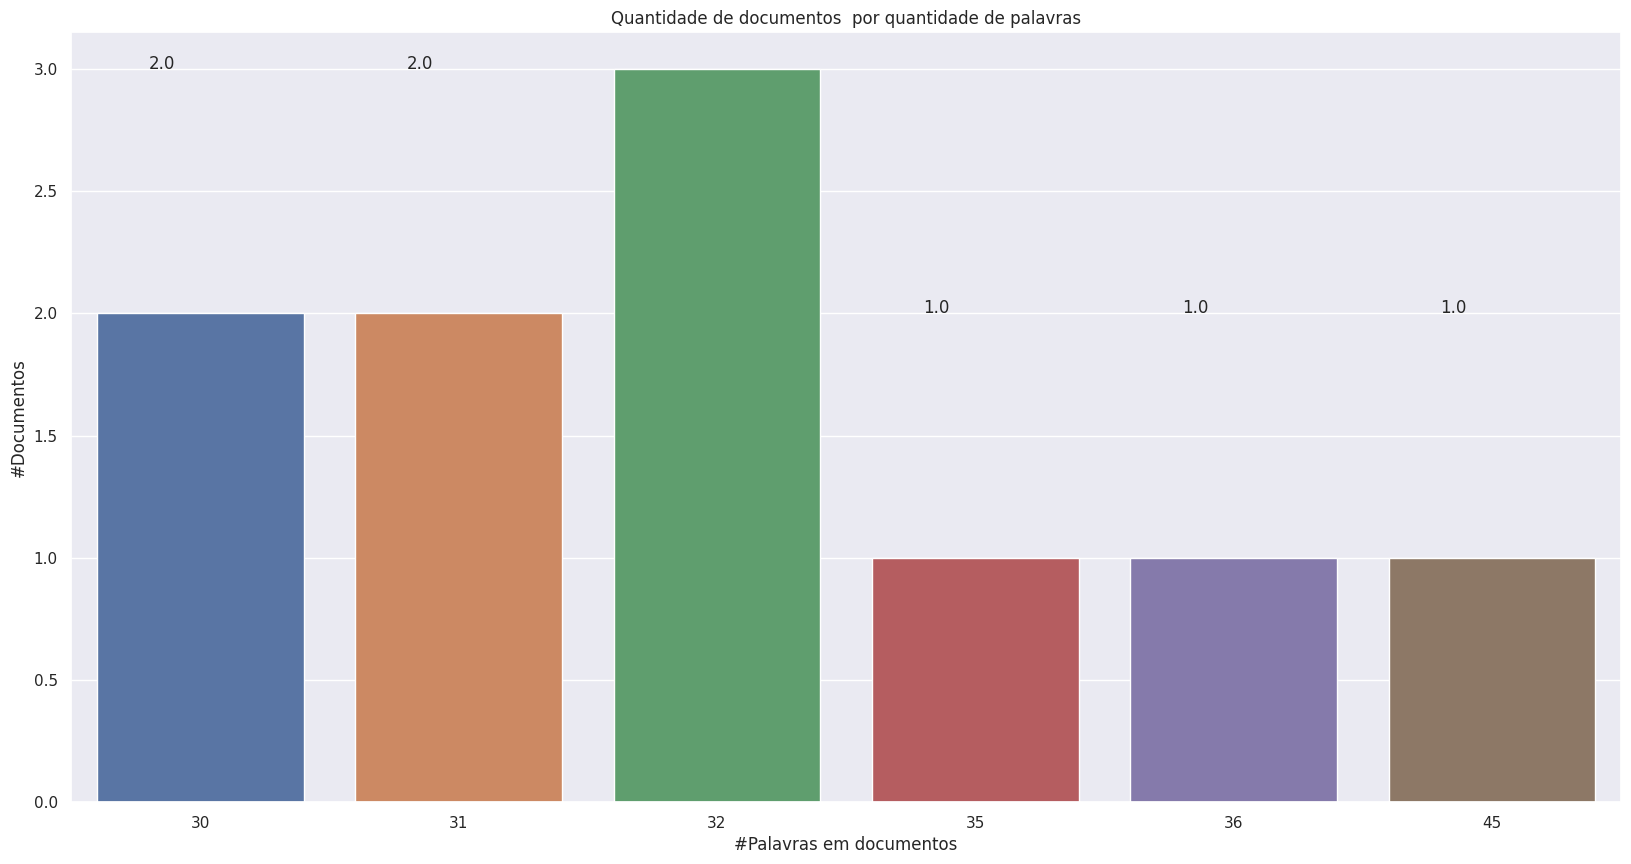

In [90]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de documentos  por quantidade de palavras")
plt.xlabel("#Palavras em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.3 Gráfico Quantidade de documentos  por quantidade de tokens

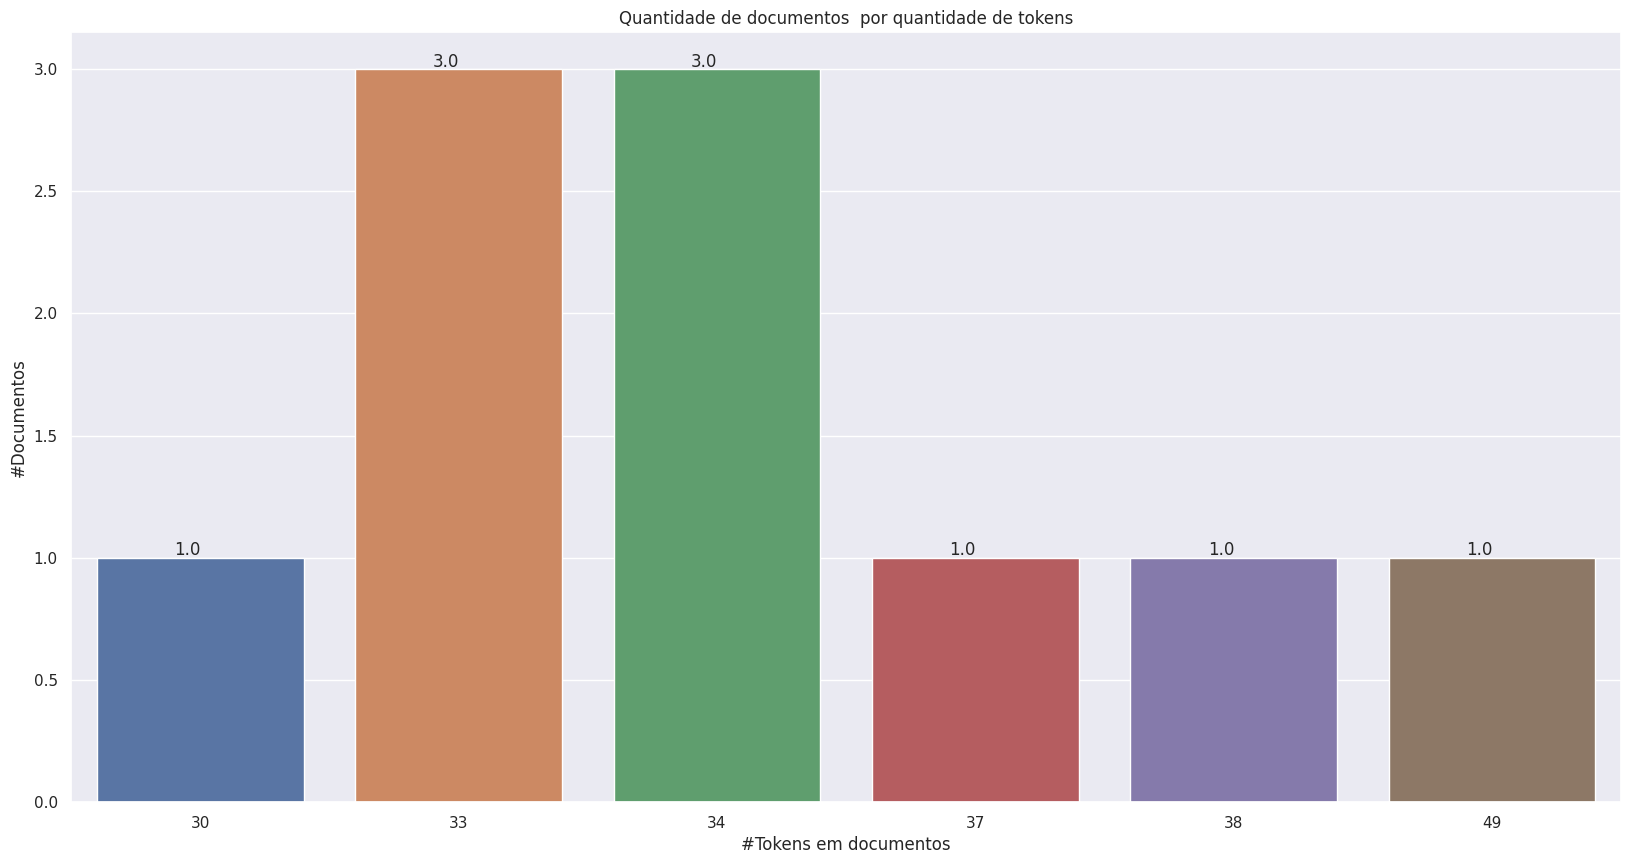

In [91]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdetokensbert"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de tokens")
plt.xlabel("#Tokens em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.4 Gráfico Quantidade de documentos  por quantidade de palavras desconsiderando as stopword

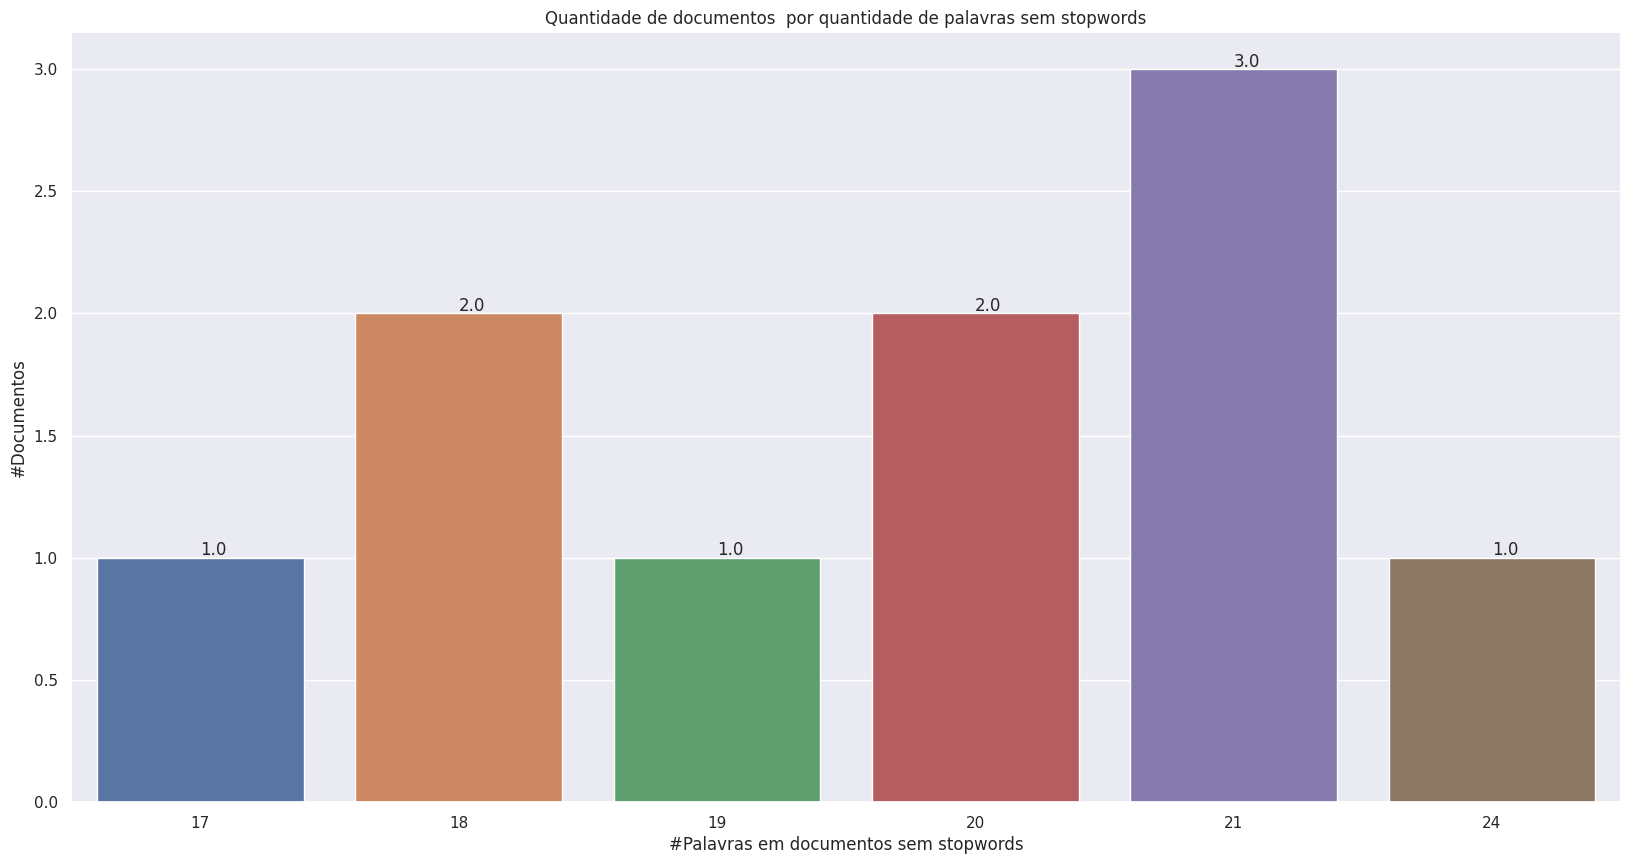

In [92]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de palavras sem stopwords")
plt.xlabel("#Palavras em documentos sem stopwords")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.5 Gráfico Quantidade de documentos  por quantidade de locuções verbais

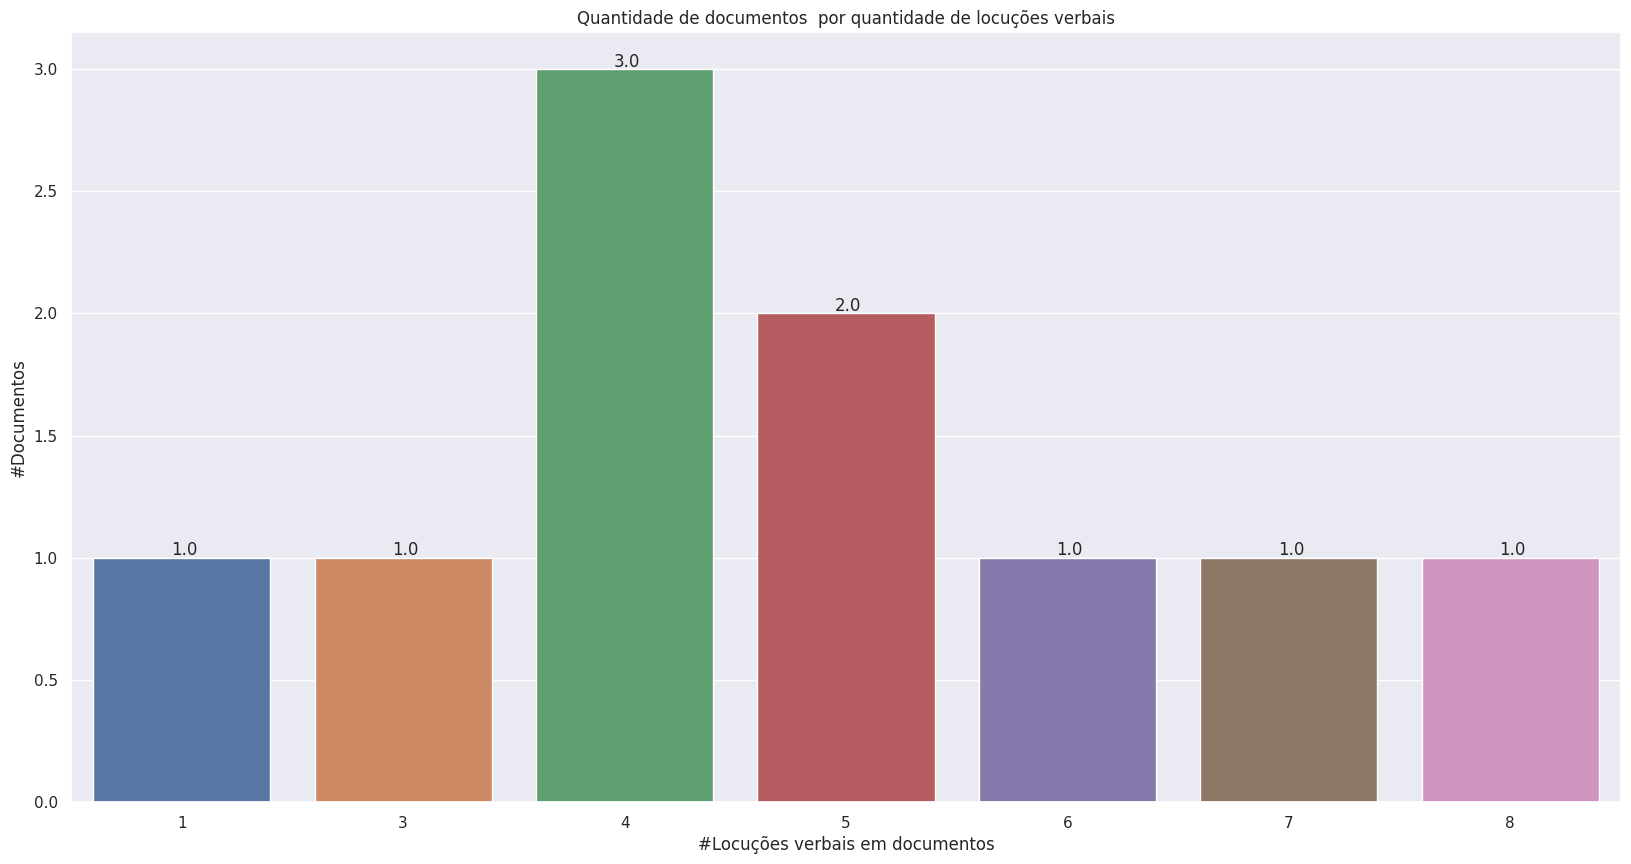

In [93]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.6 Gráfico Quantidade de documentos  por quantidade de verbos

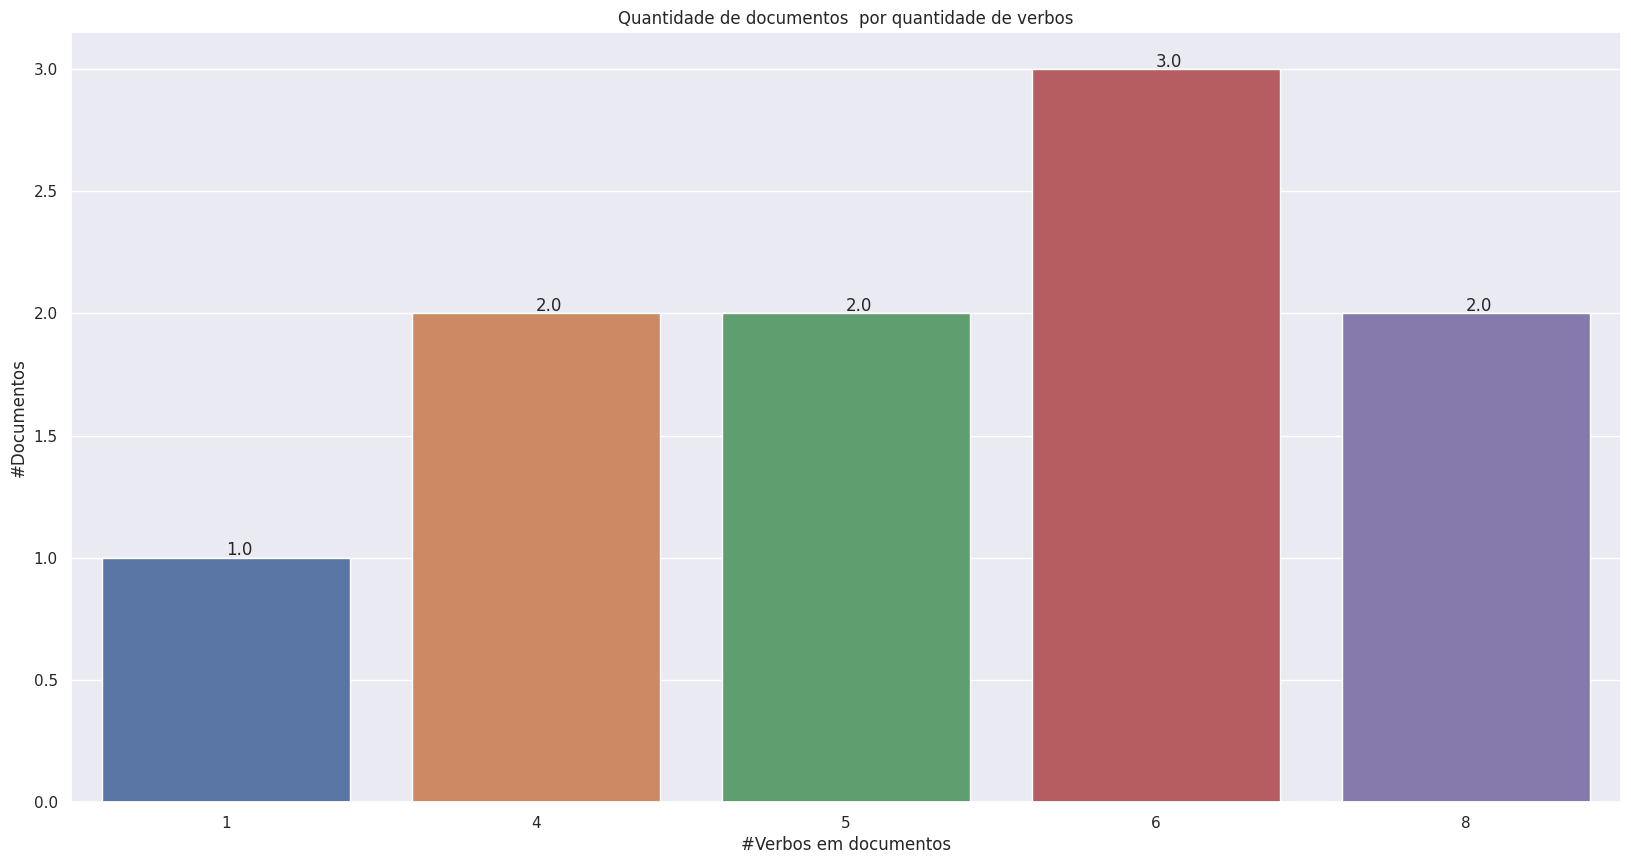

In [94]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de verbos")
plt.xlabel("#Verbos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.7 Gráfico Quantidade de documentos  por quantidade de verbos(VERB) e verbos auxiliares(AUX)

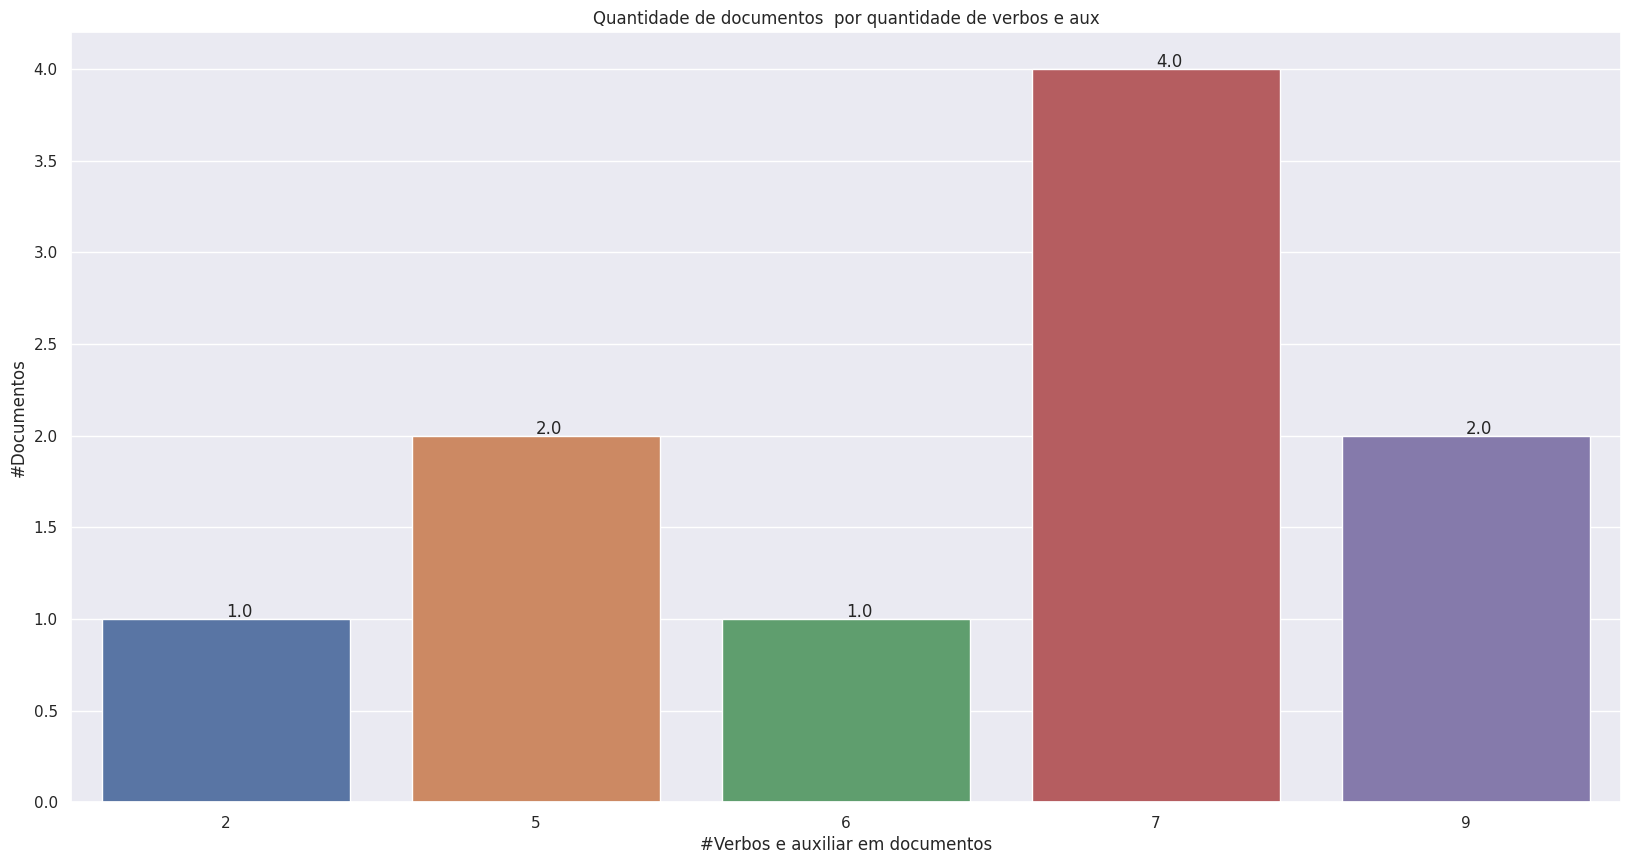

In [95]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.8 Gráfico Quantidade de documentos  por quantidade de substantivos(NOUN)

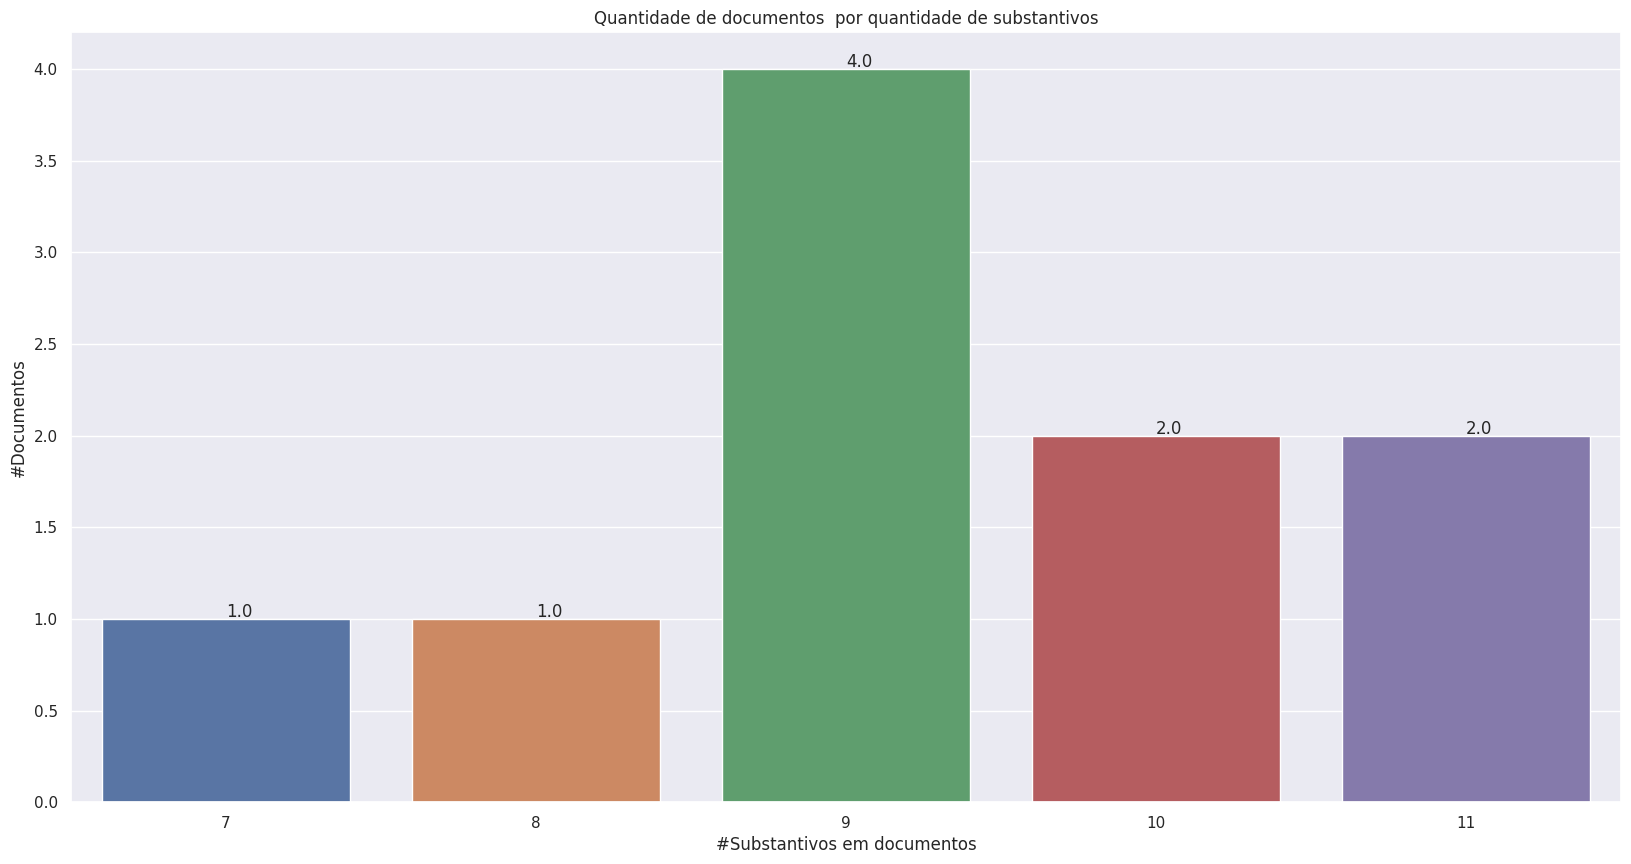

In [96]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de substantivos")
plt.xlabel("#Substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.9 Gráfico Quantidade de documentos  por quantidade de verbos(AUX) e substantivo(NOUN)

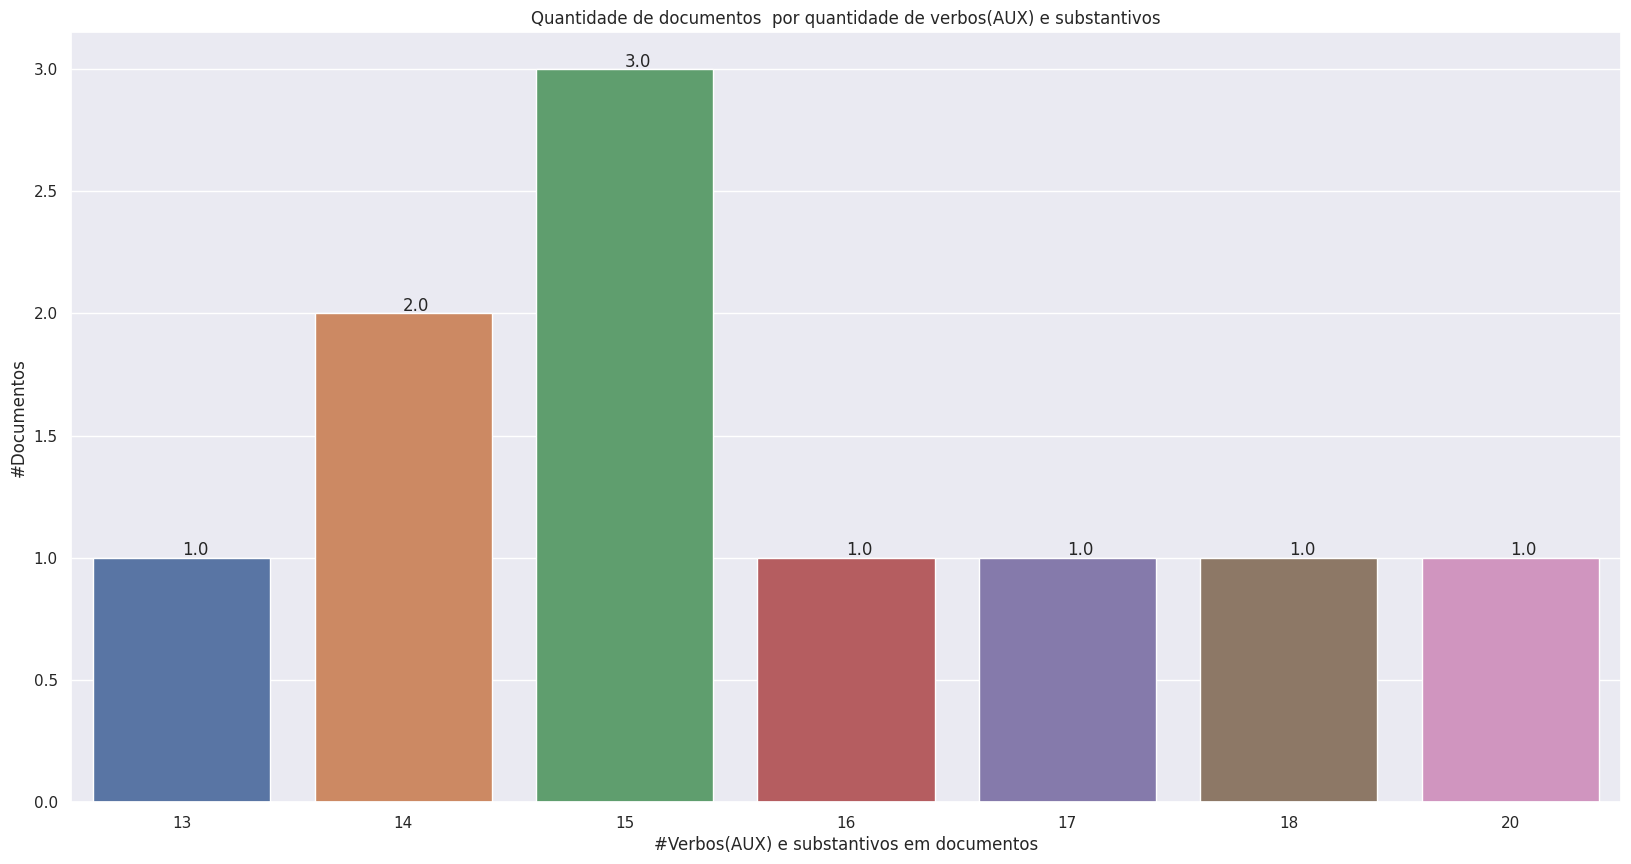

In [97]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbosauxsubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.10 Gráfico Quantidade de documentos por quantidade de entidades reconhecidas

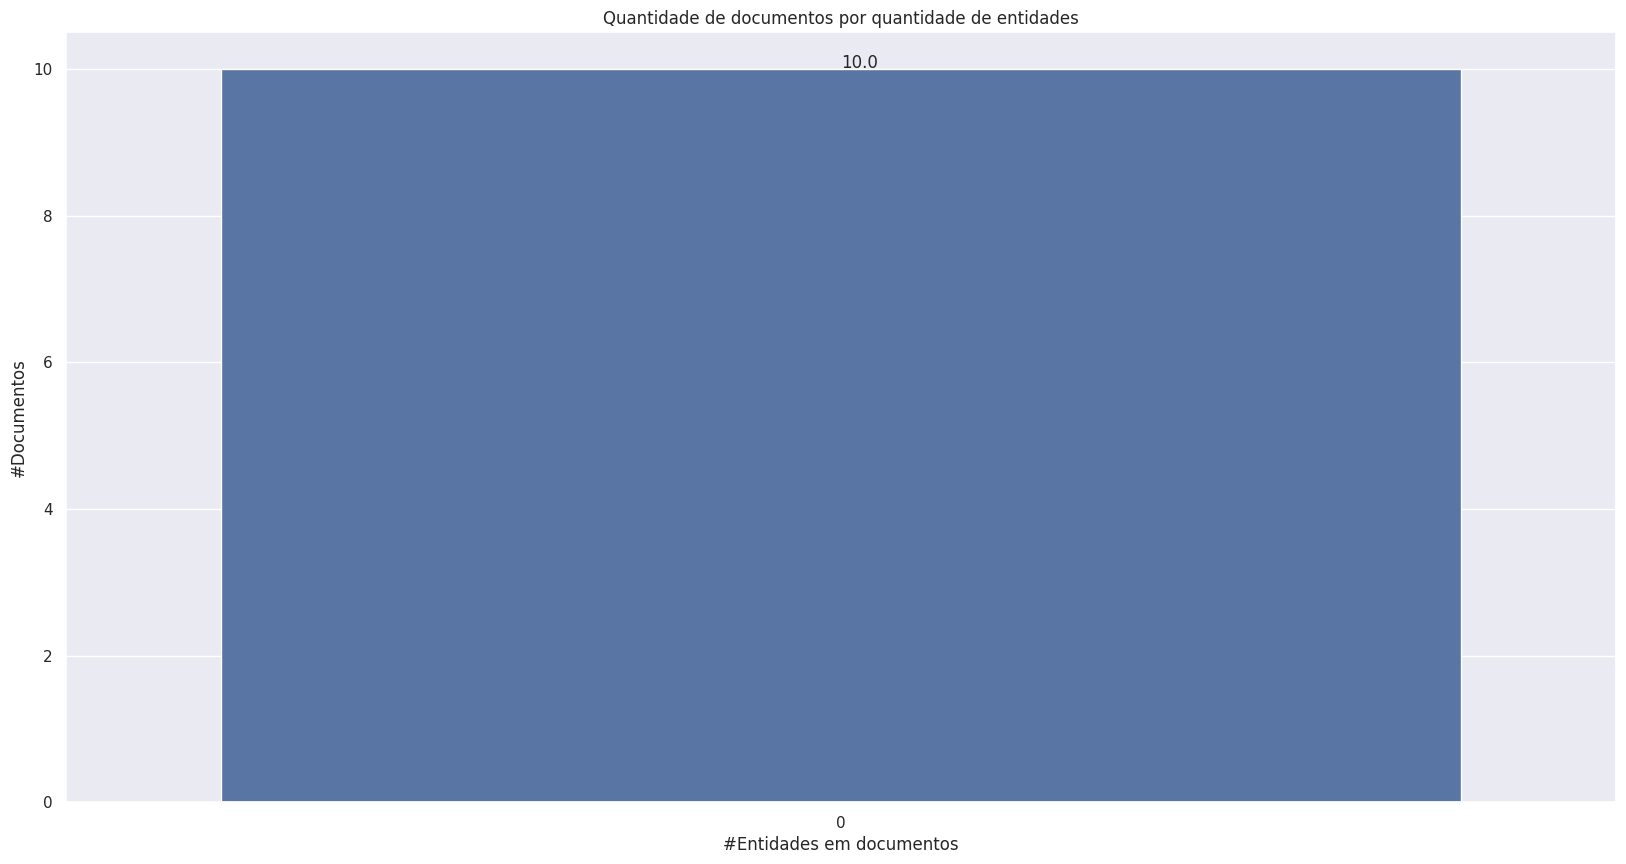

In [98]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdener"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos por quantidade de entidades")
plt.xlabel("#Entidades em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.11 Gráfico da distribuição do comprimento dos documentos tokenizados

In [99]:
# Recupera o comprimento dos documentos tokenizados
tamanhos_sentencas = [len(x) for x in documento_tokenizado]

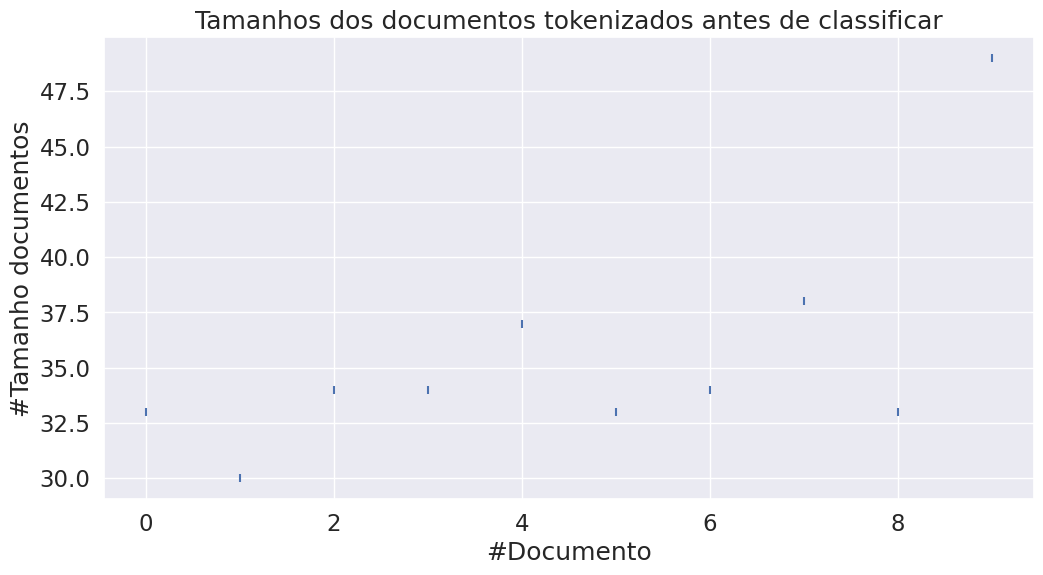

In [100]:
# Import das bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Aumenta o tamanho da plotagem e o tamanho da fonte.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Adiciona os valores as colunas
plt.scatter(range(0, len(tamanhos_sentencas)), tamanhos_sentencas, marker="|")

plt.xlabel("#Documento")
plt.ylabel("#Tamanho documentos")
plt.title("Tamanhos dos documentos tokenizados antes de classificar")

plt.show()

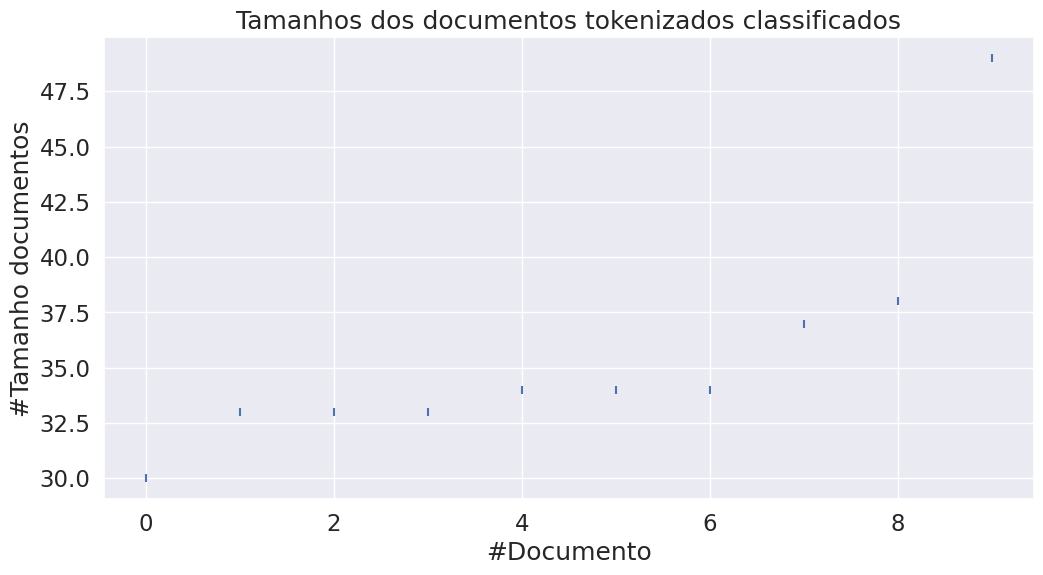

In [101]:
# Import das bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(tamanhos_sentencas)), sorted(tamanhos_sentencas), marker="|")

plt.xlabel("#Documento")
plt.ylabel("#Tamanho documentos")
plt.title("Tamanhos dos documentos tokenizados classificados")

plt.show()

### 5.2.6 Por sentença

#### 5.2.6.1 Gráfico Quantidade de sentenças de documentos  por quantidade de palavras

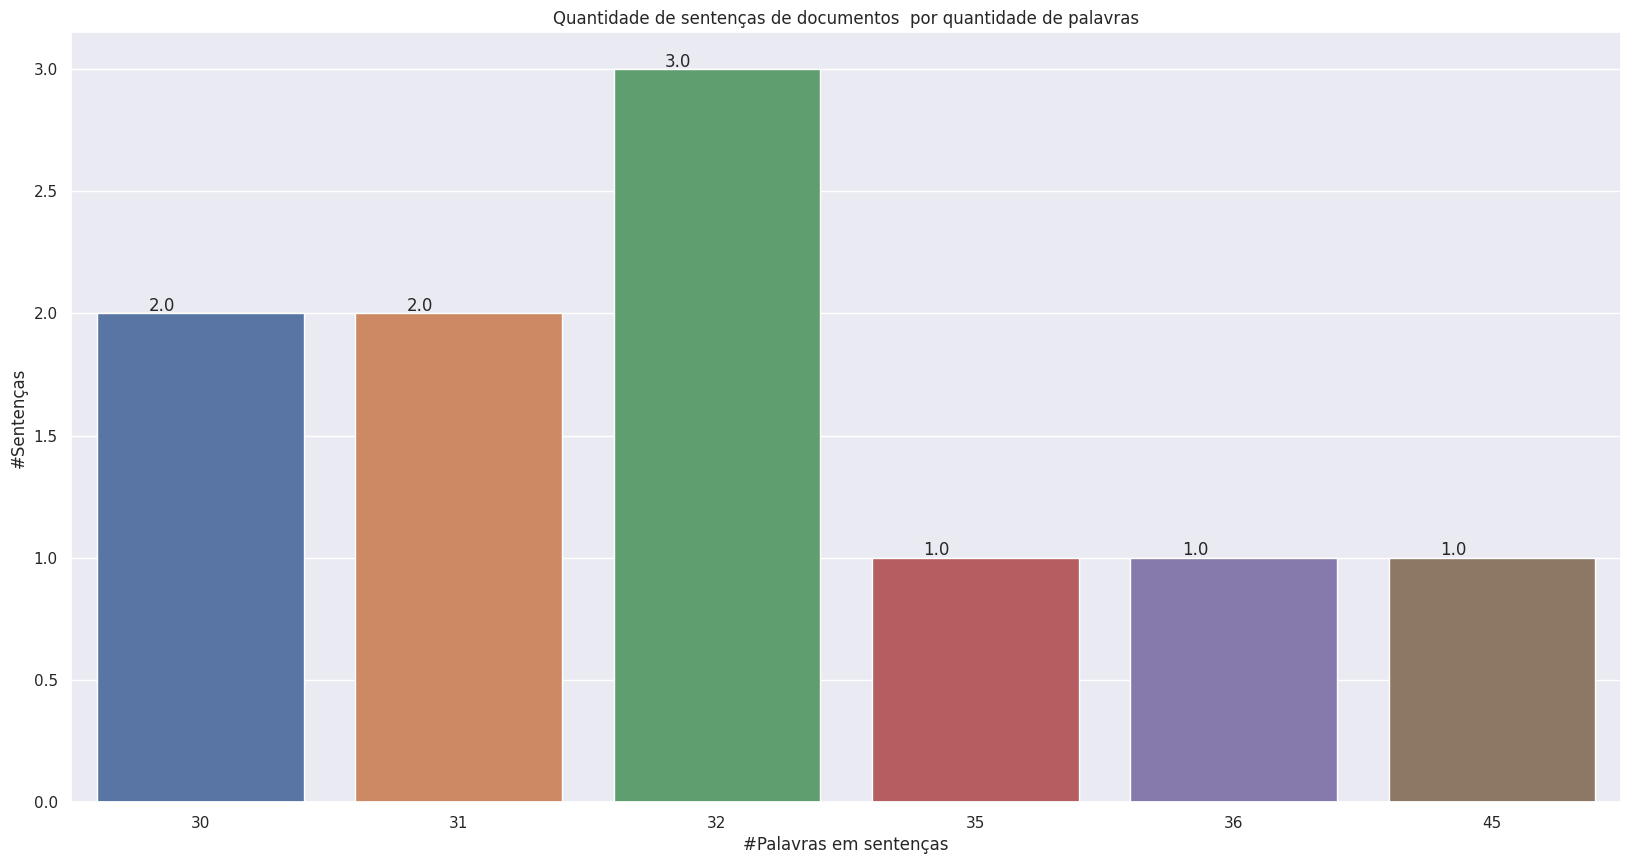

In [102]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+0.01))

plt.title("Quantidade de sentenças de documentos  por quantidade de palavras")
plt.xlabel("#Palavras em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.2 Gráfico Quantidade de sentenças de documentos  por quantidade de tokens

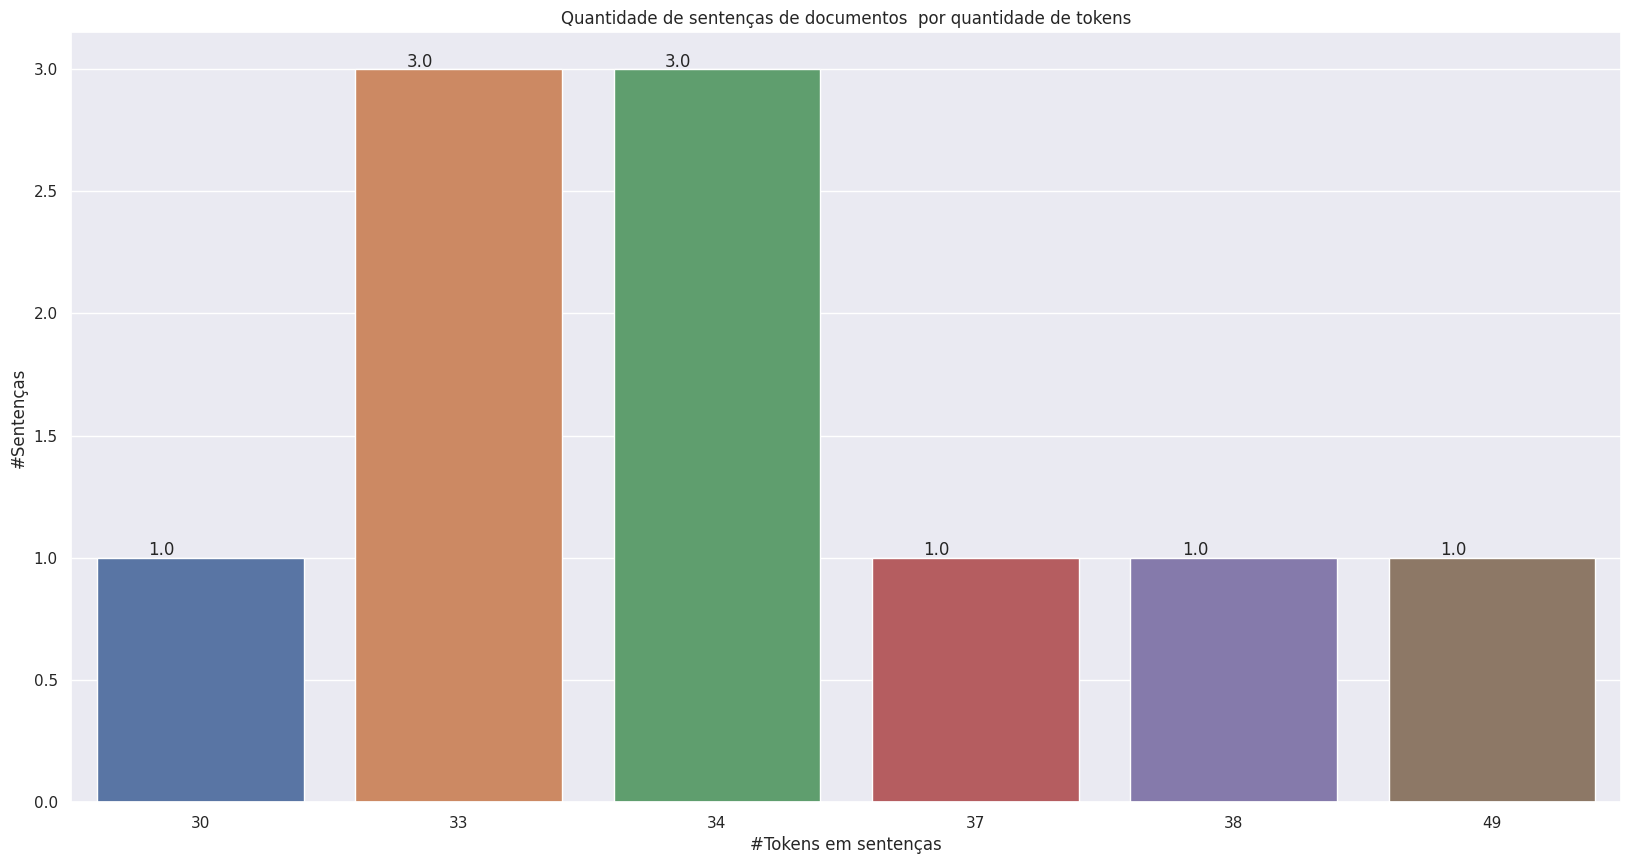

In [103]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdetokensbert"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+0.01))

plt.title("Quantidade de sentenças de documentos  por quantidade de tokens")
plt.xlabel("#Tokens em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.3 Gráfico Quantidade de sentenças de documentos  por quantidade de palavras desconsiderando stopwords

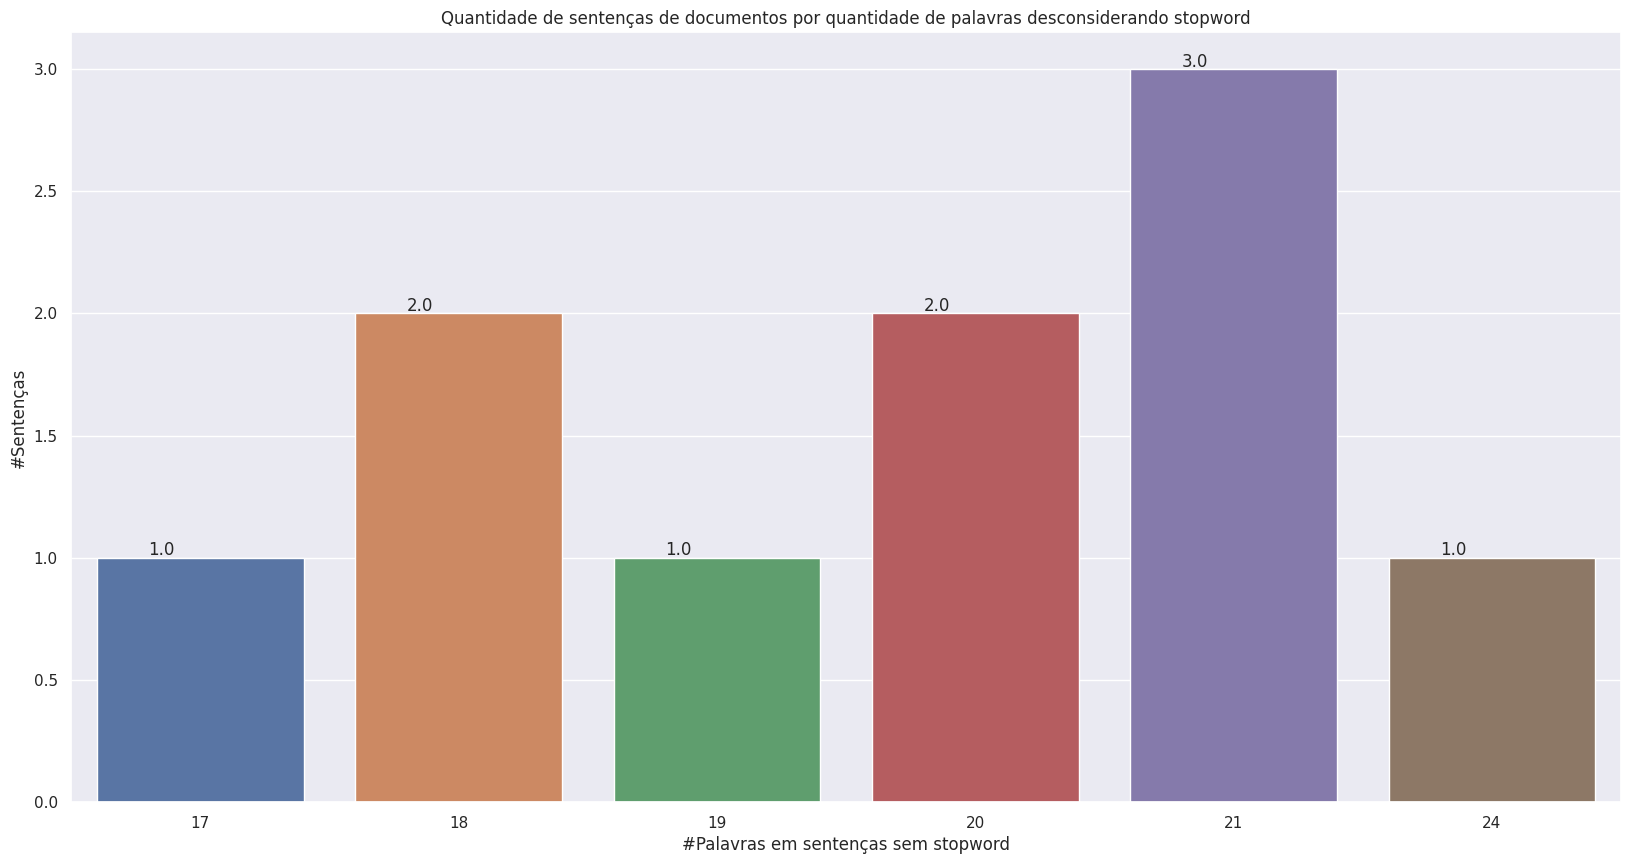

In [104]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+0.01))

plt.title("Quantidade de sentenças de documentos por quantidade de palavras desconsiderando stopword")
plt.xlabel("#Palavras em sentenças sem stopword")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.4 Gráfico Quantidade de sentenças de documentos  por quantidade de locuções verbais

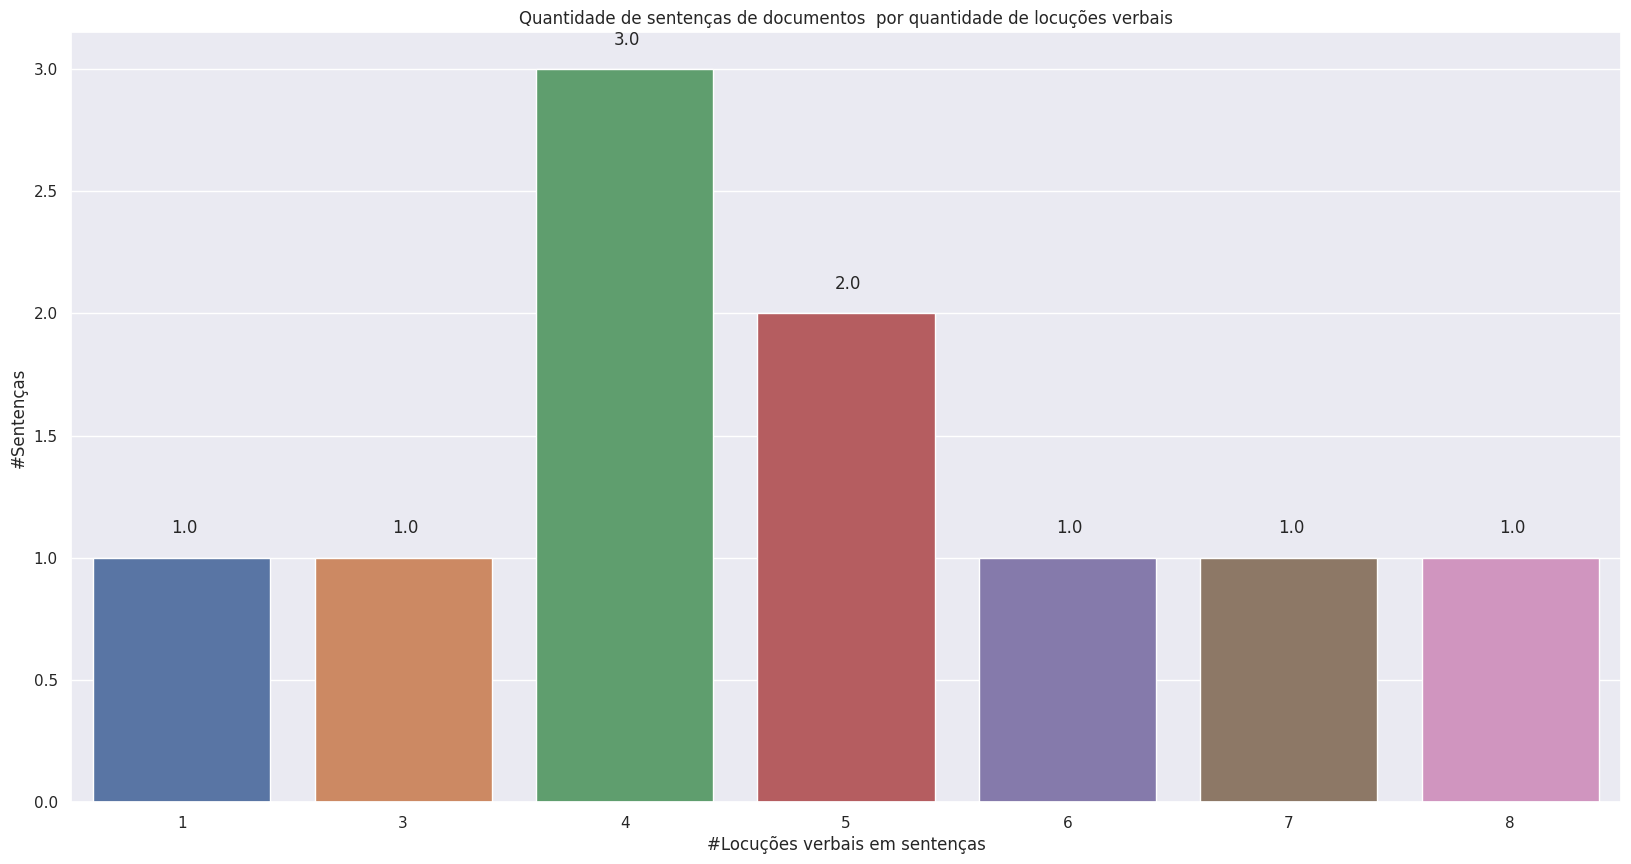

In [105]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.5 Gráfico Quantidade de sentenças de documentos  por quantidade de verbos(VERB)

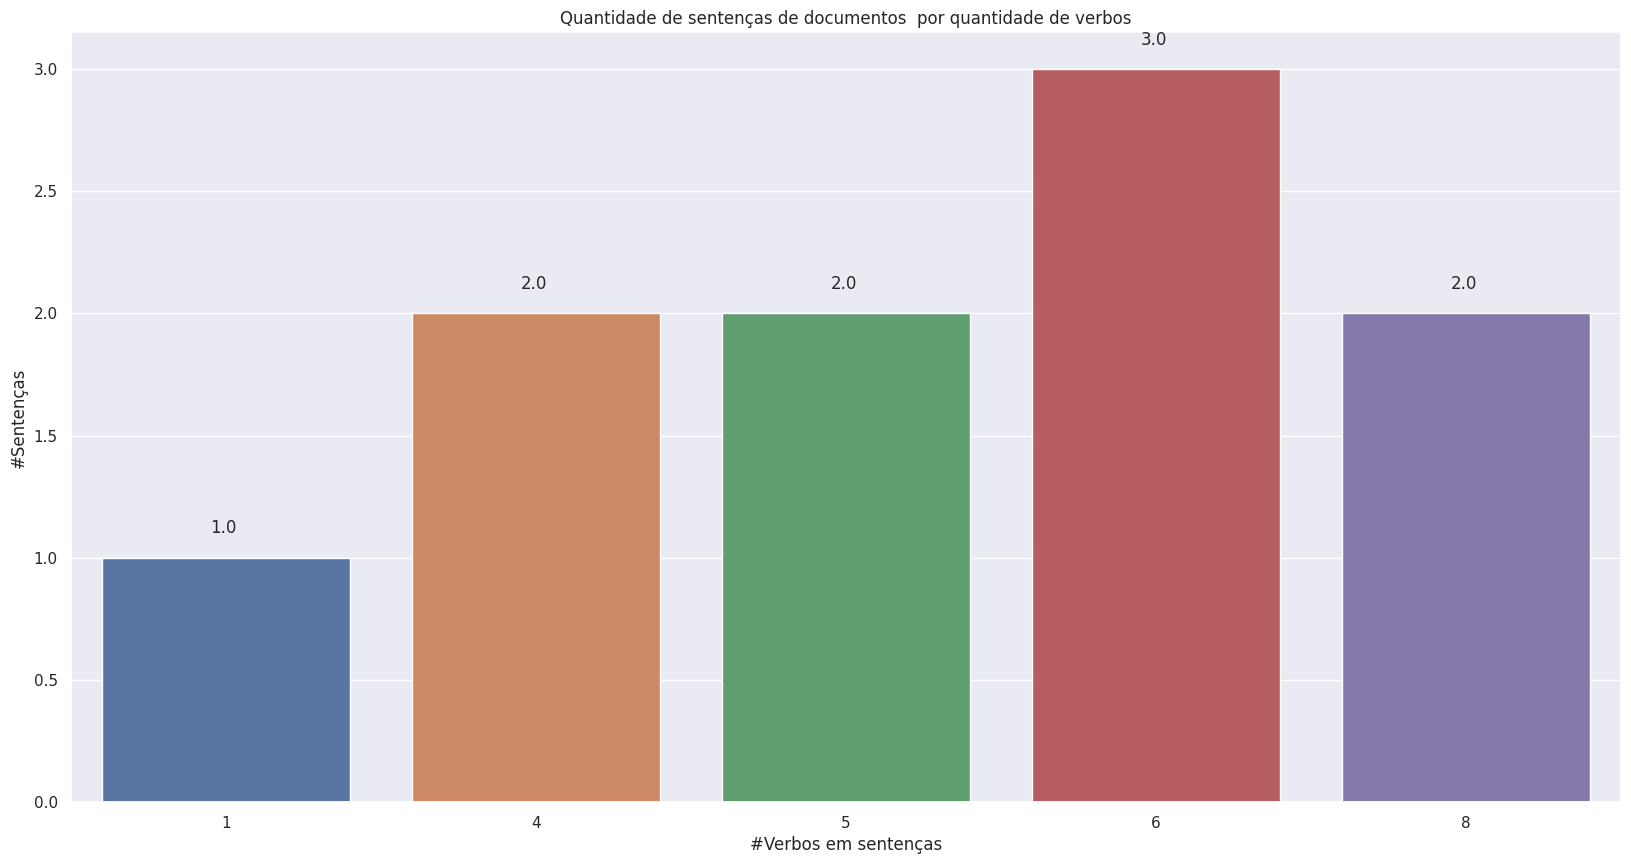

In [106]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de verbos")
plt.xlabel("#Verbos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.6 Gráfico Quantidade de sentenças de documentos  por quantidade de verbos(VERB) e verbos auxiliares(AUX)

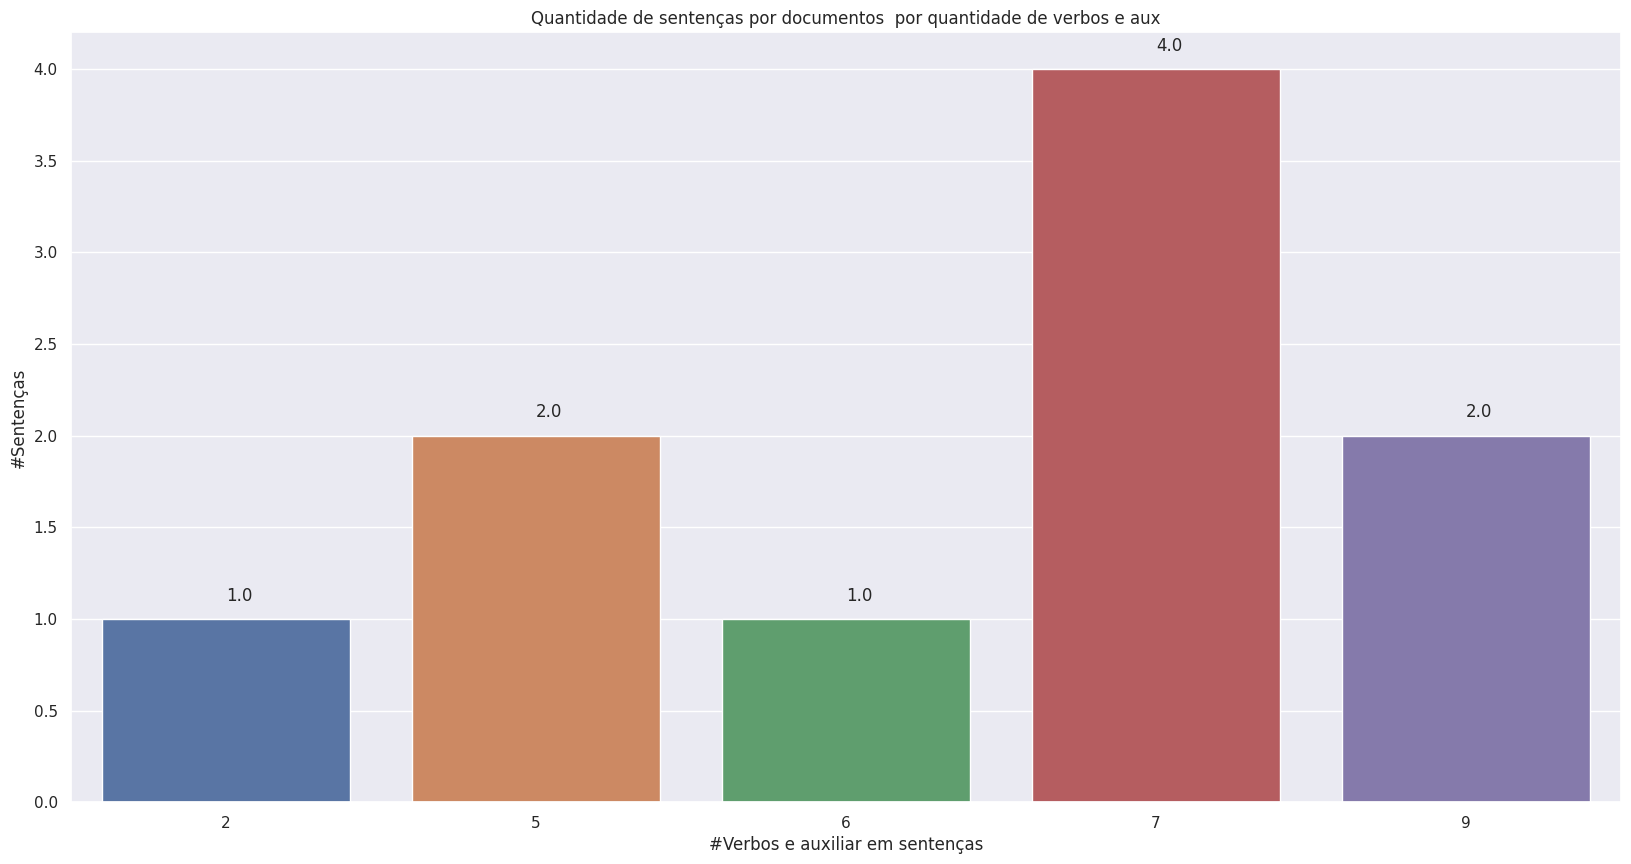

In [107]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças por documentos  por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.7 Gráfico Quantidade de sentenças de documentos  por quantidade de substantivos(NOUN)

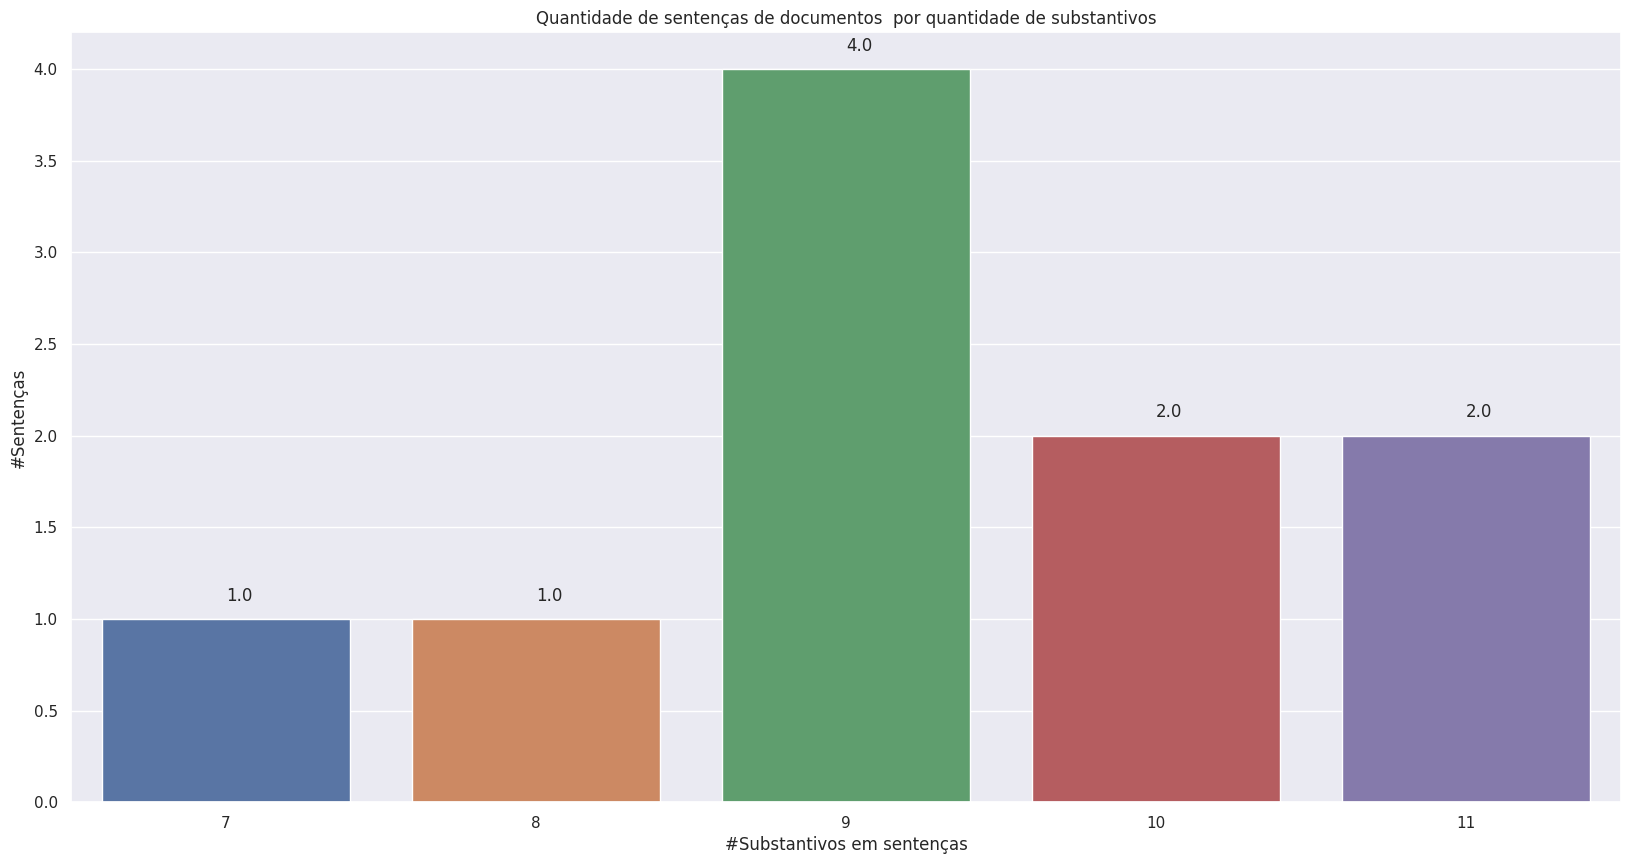

In [108]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de substantivos")
plt.xlabel("#Substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.8 Gráfico Quantidade de sentenças de documentos  por quantidade de verbos(AUX) e substantivo

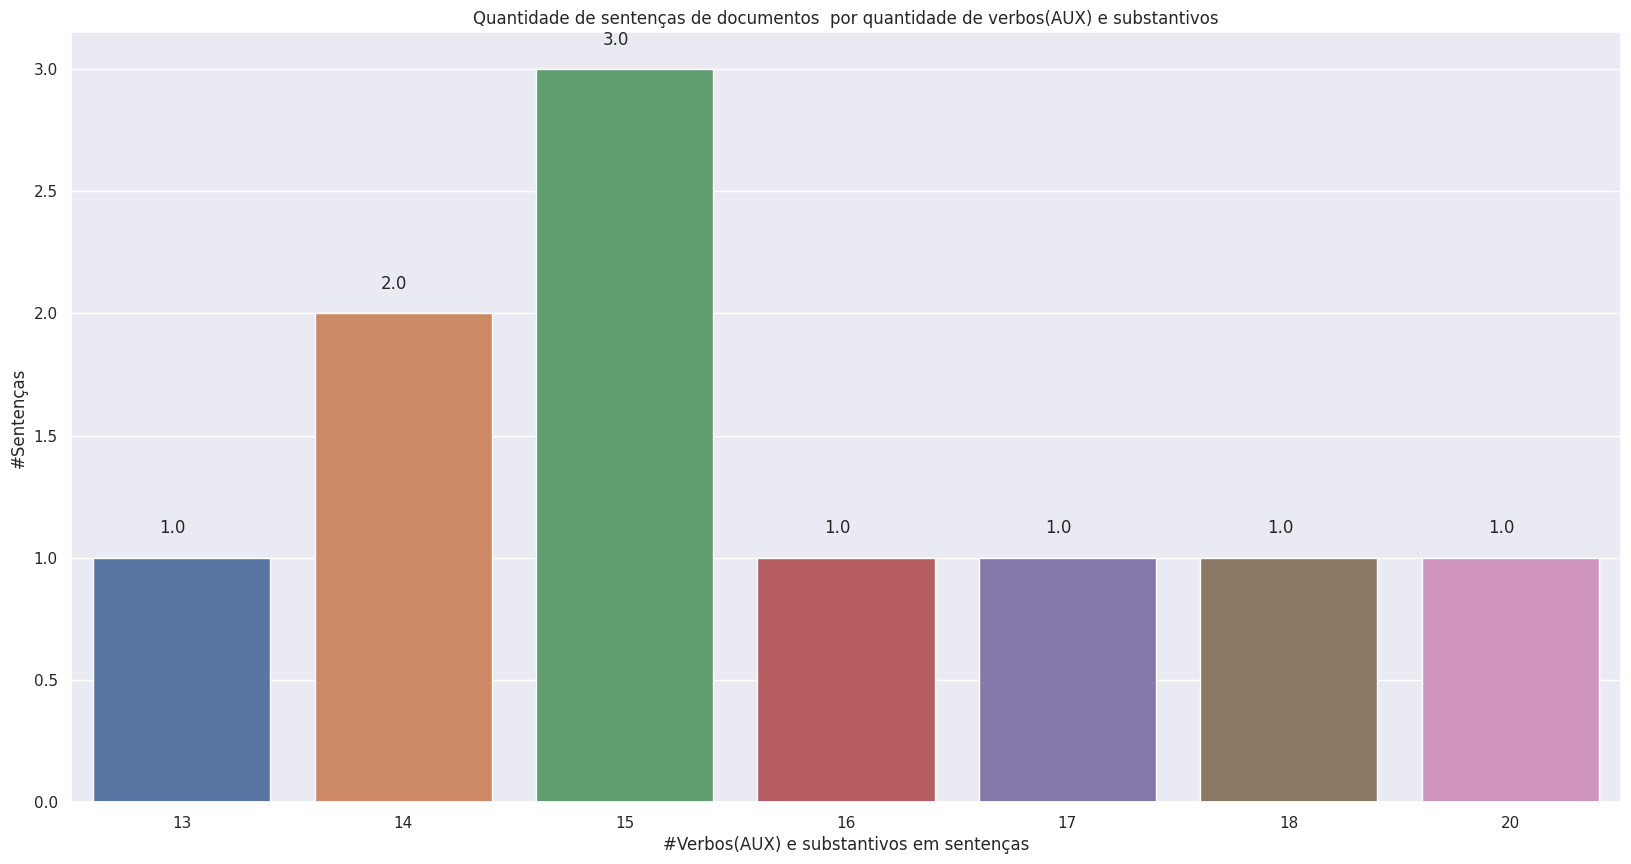

In [109]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboauxsubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.9 Gráfico Quantidade de sentenças de documentos  por quantidade de entidades

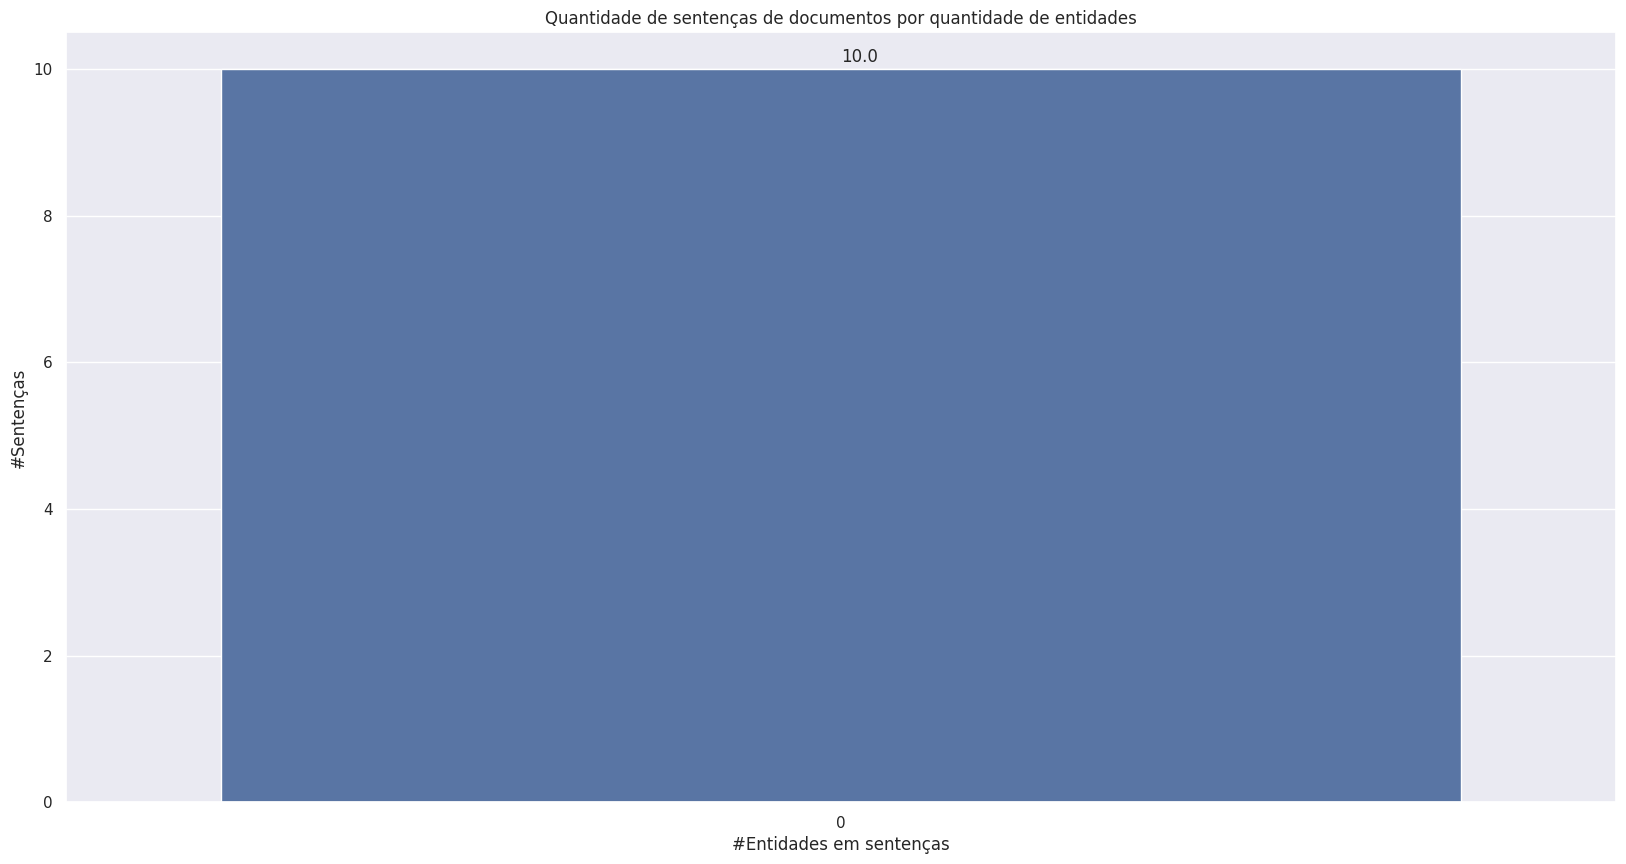

In [110]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdener"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos por quantidade de entidades")
plt.xlabel("#Entidades em sentenças")
plt.ylabel("#Sentenças")

plt.show()

# 6 Finalização

## 6.1 Tempo final de processamento



In [111]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:04:00 (h:mm:ss)
